# 0 **Imports**

In [1]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import scikitplot          as skplt
import matplotlib.gridspec as gridspec
import xgboost             as xgb
import lightgbm            as lightgbm
import matplotlib
import pickle
import random
import warnings;warnings.filterwarnings("ignore")

from pylab                     import rcParams
from matplotlib                import pyplot           as plt
from scipy                     import stats            as ss
from sklearn                   import model_selection  as ms
from sklearn                   import preprocessing    as pp
from sklearn                   import ensemble         as en
from sklearn                   import linear_model     as lm
from sklearn                   import neighbors        as nh
from sklearn.tree              import DecisionTreeClassifier
from sklearn.metrics           import top_k_accuracy_score
from sklearn.metrics           import accuracy_score, f1_score,classification_report
from sklearn.model_selection   import GridSearchCV
from sklearn.model_selection   import cross_val_score
from sklearn.model_selection   import cross_val_predict
from sklearn.model_selection   import cross_validate
from fast_ml.model_development import train_valid_test_split

##  **0.1 Helper functions**

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

## **0.2 Loading data**

In [29]:
df_insurance_raw=pd.read_csv('../data/insurance_202206101822.csv')
df_users_raw=pd.read_csv('../data/users_202206101824.csv')
df_vehicles_raw=pd.read_csv('../data/vehicle_202206101824.csv')

# merge
df_raw=pd.merge(df_insurance_raw,df_users_raw,how='left',on='id')
df_raw=pd.merge(df_raw,df_vehicles_raw,how='left',on='id')

# **1 Data description**

In [30]:
df1=df_raw.copy()

In [31]:
df1

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,40454.0,217,1,Male,44,28.0,26.0,1,> 2 Years,Yes
1,2,0,33536.0,183,0,Male,76,3.0,26.0,1,1-2 Year,No
2,3,0,38294.0,27,1,Male,47,28.0,26.0,1,> 2 Years,Yes
3,4,1,28619.0,203,0,Male,21,11.0,152.0,1,< 1 Year,No
4,5,1,27496.0,39,0,Female,29,41.0,152.0,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,30170.0,88,0,Male,74,26.0,26.0,1,1-2 Year,No
381105,381106,1,40016.0,131,0,Male,30,37.0,152.0,1,< 1 Year,No
381106,381107,1,35118.0,161,0,Male,21,30.0,160.0,1,< 1 Year,No
381107,381108,0,44617.0,74,0,Female,68,14.0,124.0,1,> 2 Years,Yes


## **1.1 Data types**

In [68]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## **1.2 Change types**

In [69]:
df1['region_code']=df1['region_code'].astype('int64')
df1['policy_sales_channel']=df1['policy_sales_channel'].astype('int64')

## **1.3 Check NA**

In [70]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## **1.4 Descriptive statistics**

In [71]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

### **1.4.1 Numerical attributes**

In [72]:
# Central Tendency - mean, median 
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min () )).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
2,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
3,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
4,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
5,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
6,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302


### **1.4.2 Categorical attributes**

In [73]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

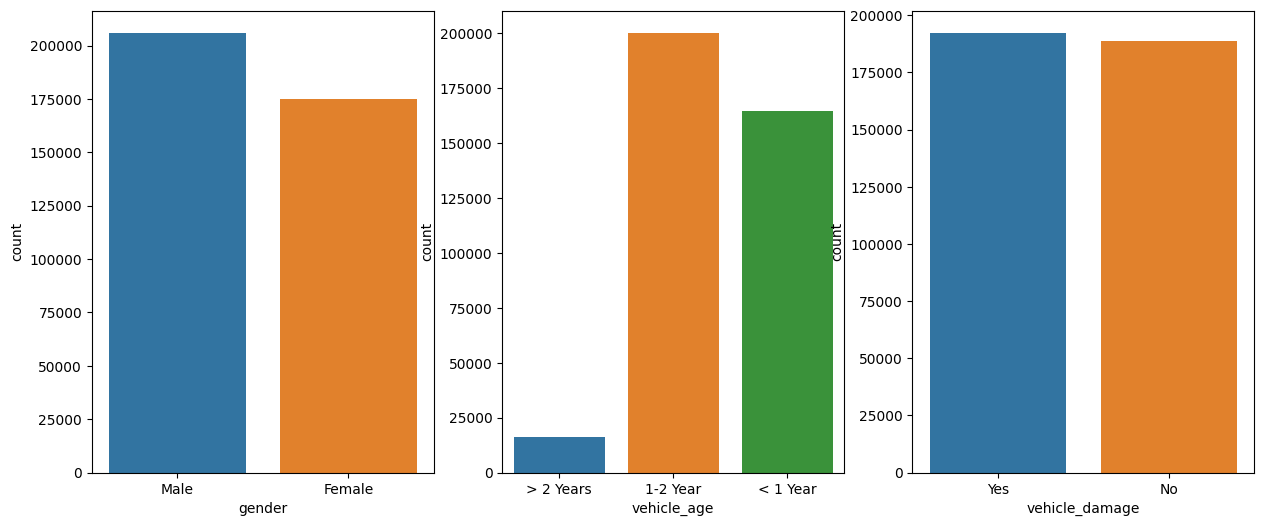

In [74]:
rcParams['figure.figsize'] = 15,6

plt.subplot(1,3,1);
sns.countplot(x='gender',data=df1);

plt.subplot(1,3,2);
sns.countplot(x='vehicle_age',data=df1);

plt.subplot(1,3,3);
sns.countplot(x='vehicle_damage',data=df1);

# **2 Feature engineering**

In [75]:
df2=df1.copy()

In [76]:
# vehicle age
df2['vehicle_age']=df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' 
                                            else 'between_1_2_years' if x == '1-2 Year'
                                            else 'below_1_year')

# previously insured
df2['previously_insured']=df2['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

# driving license
df2['driving_license']=df2['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')

# **3 Variable filtering**

In [77]:
df3=df2.copy()

## <s>**3.1 Row filtering**<s/>

## <s>**3.2 Column filtering**<s/>

# **4 Exploratory data analysis**

In [78]:
df4=df3.copy()

## **4.1 Univariate analysis**

### **4.1.1 Response variable**

response
0    334399
1     46710
Name: count, dtype: int64

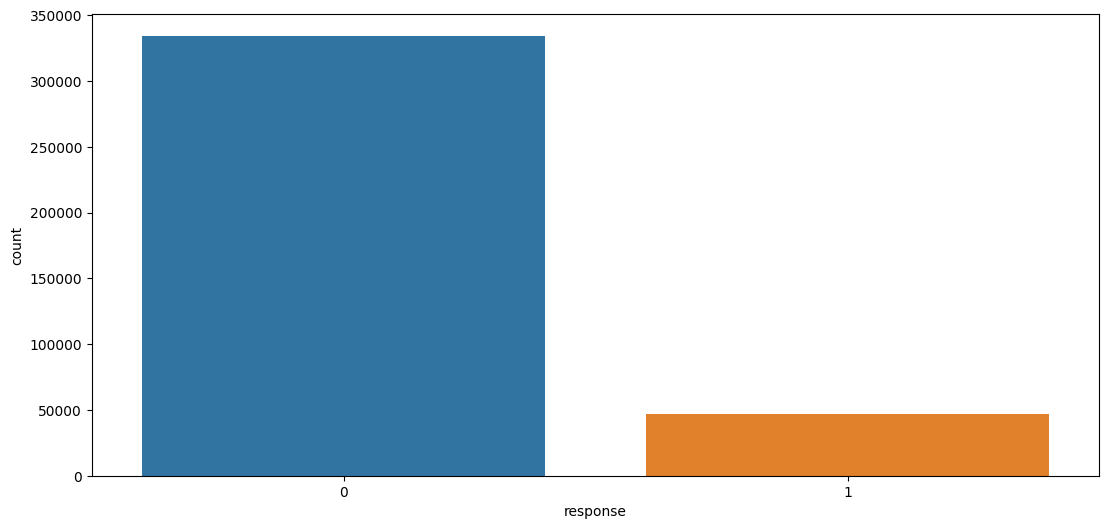

In [17]:
rcParams['figure.figsize'] = 13,6

sns.countplot(x='response',data=df4);
df4['response'].value_counts()

### **4.1.2 Numerical variables**

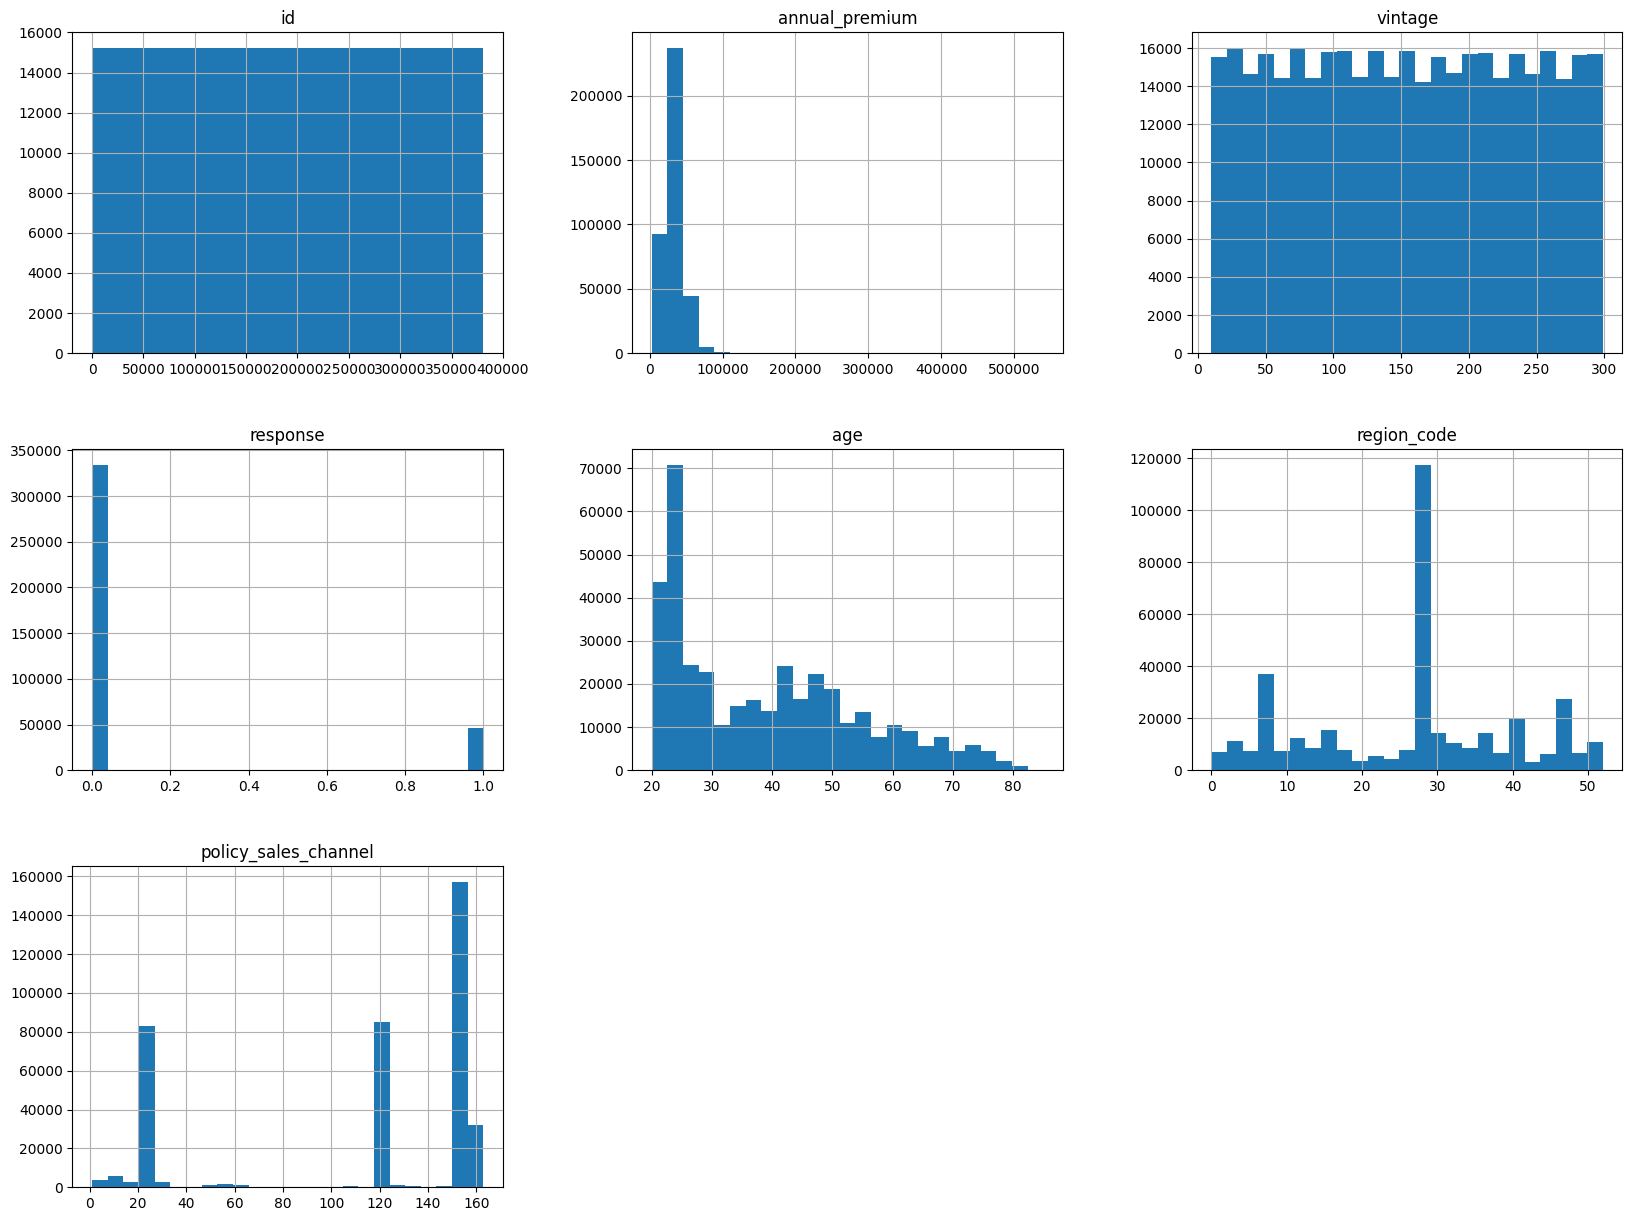

In [18]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64'])

rcParams['figure.figsize'] = 20,15
num_attributes.hist(bins=25);

### **4.1.3 Categorical variables**

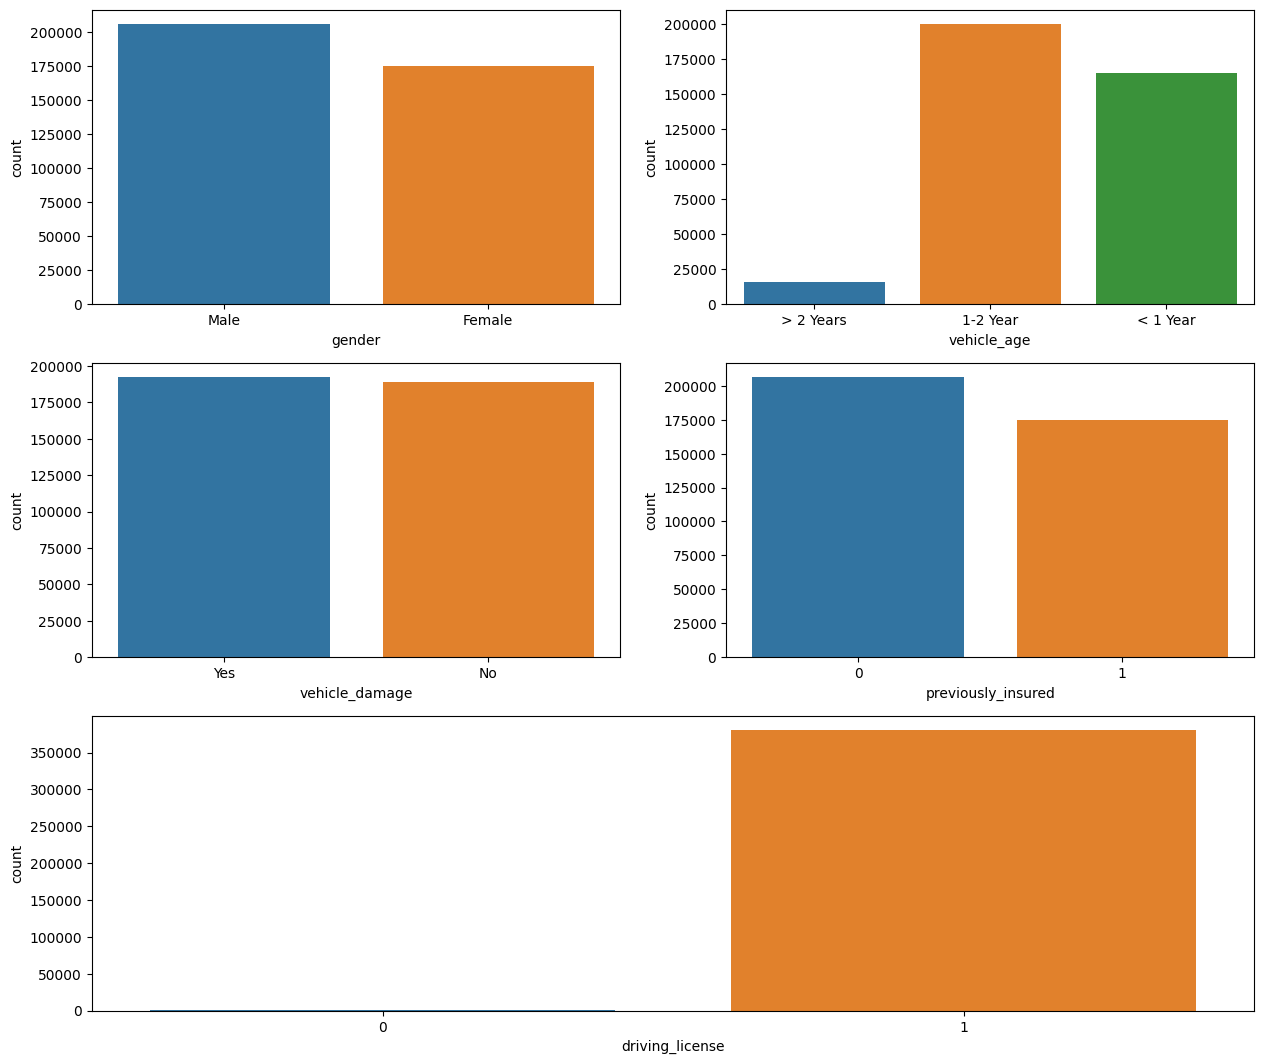

In [19]:
rcParams['figure.figsize'] = 15,13

grid=gridspec.GridSpec(3,2)

plt.subplot(grid[0,0])
sns.countplot(x='gender',data=df1);

plt.subplot(grid[0,1])
sns.countplot(x='vehicle_age',data=df1);

plt.subplot(grid[1,0])
sns.countplot(x='vehicle_damage',data=df1);

plt.subplot(grid[1,1])
sns.countplot(x='previously_insured',data=df1);

plt.subplot(grid[2,:])
sns.countplot(x='driving_license',data=df1);

## **4.2 Bivariate analysis**


### **4.2.1 Annual_premium**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


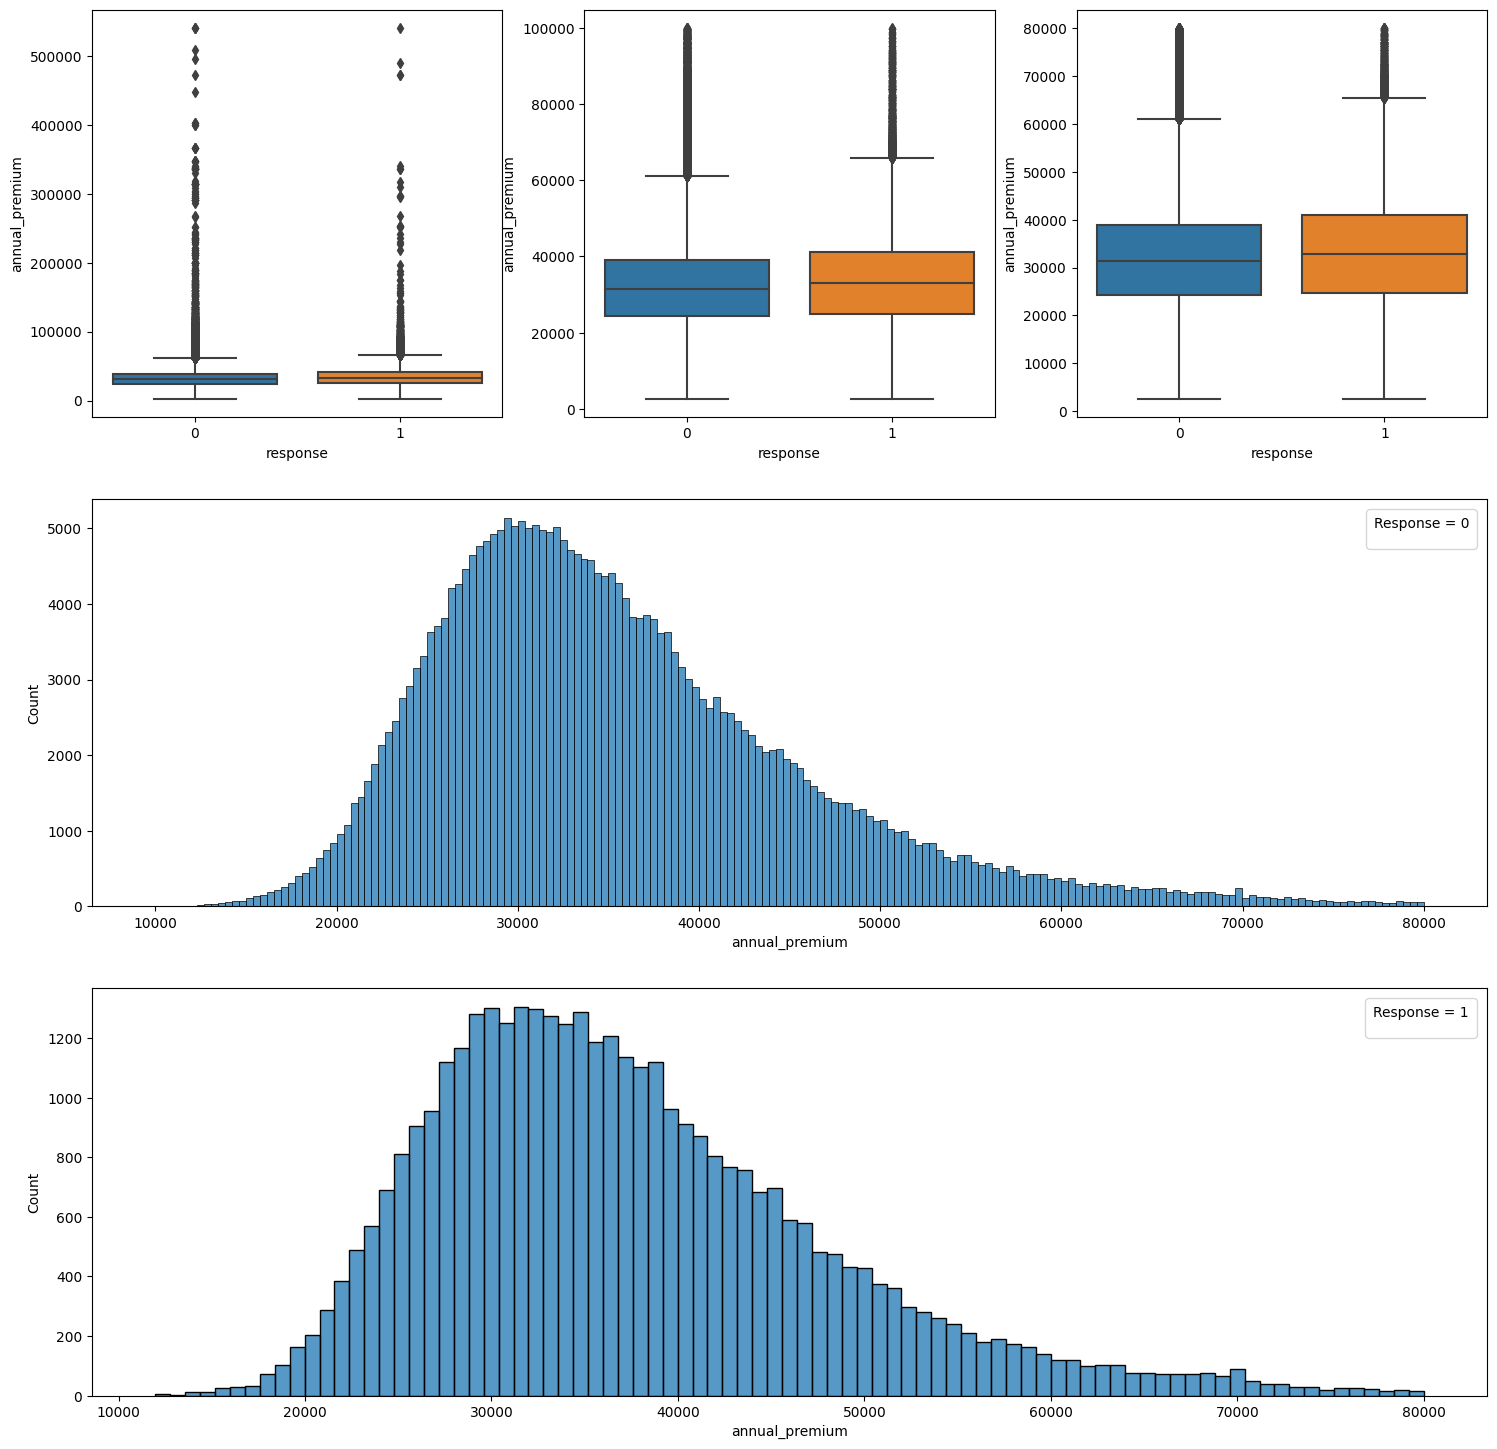

In [20]:
rcParams['figure.figsize'] = 18,18
grid=gridspec.GridSpec(3,3)


plt.subplot(grid[0,0])
sns.boxplot(x='response',y='annual_premium',data=df4); 

aux4=df4[df4['annual_premium'] < 100000]
plt.subplot(grid[0,1])
sns.boxplot(x='response',y='annual_premium',data=aux4);


aux4=df4[df4['annual_premium'] < 80000]
plt.subplot(grid[0,2])
sns.boxplot(x='response',y='annual_premium',data=aux4);


aux=df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00=aux.loc[df4['response']==0,'annual_premium']     
plt.subplot(grid[1,:])

plt.legend(title='Response = 0', fontsize="x-large")
sns.histplot(aux00);

aux00=aux.loc[df4['response']==1,'annual_premium'] 
plt.subplot(grid[2,:])
plt.legend(title='Response = 1', fontsize="x-large")
sns.histplot(aux00);

### **4.2.2 Vintage**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


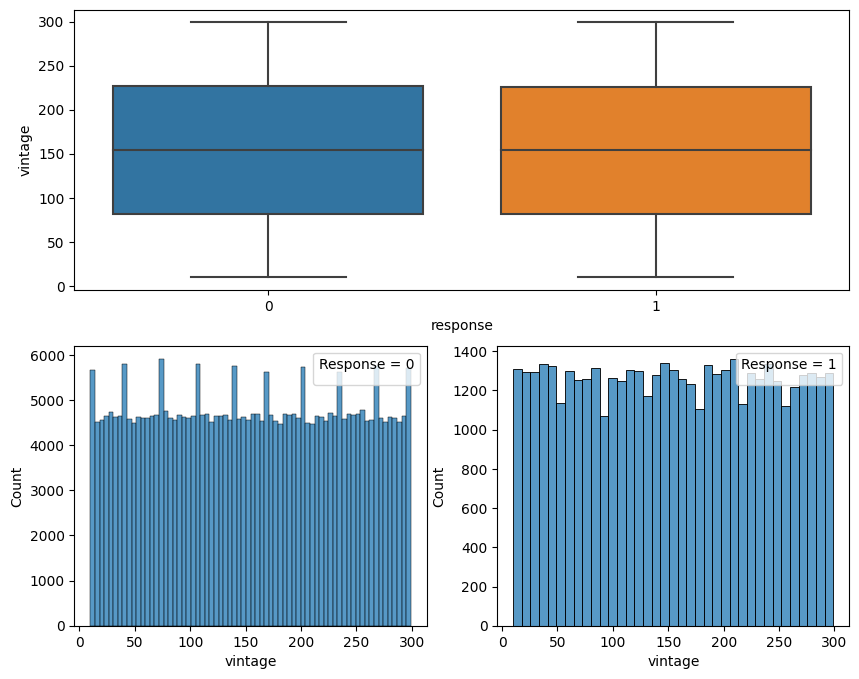

In [21]:
rcParams['figure.figsize'] = 10,8

grid=gridspec.GridSpec(2,2)

plt.subplot(grid[0,:])
sns.boxplot(x='response',y='vintage',data=df4);

plt.subplot(grid[1,0])
plt.legend(title='Response = 0')
sns.histplot(df4.loc[df4['response']==0,'vintage']);

plt.subplot(grid[1,1])
plt.legend(title='Response = 1')
sns.histplot(df4.loc[df4['response']==1,'vintage']);

### **4.2.3 Age**

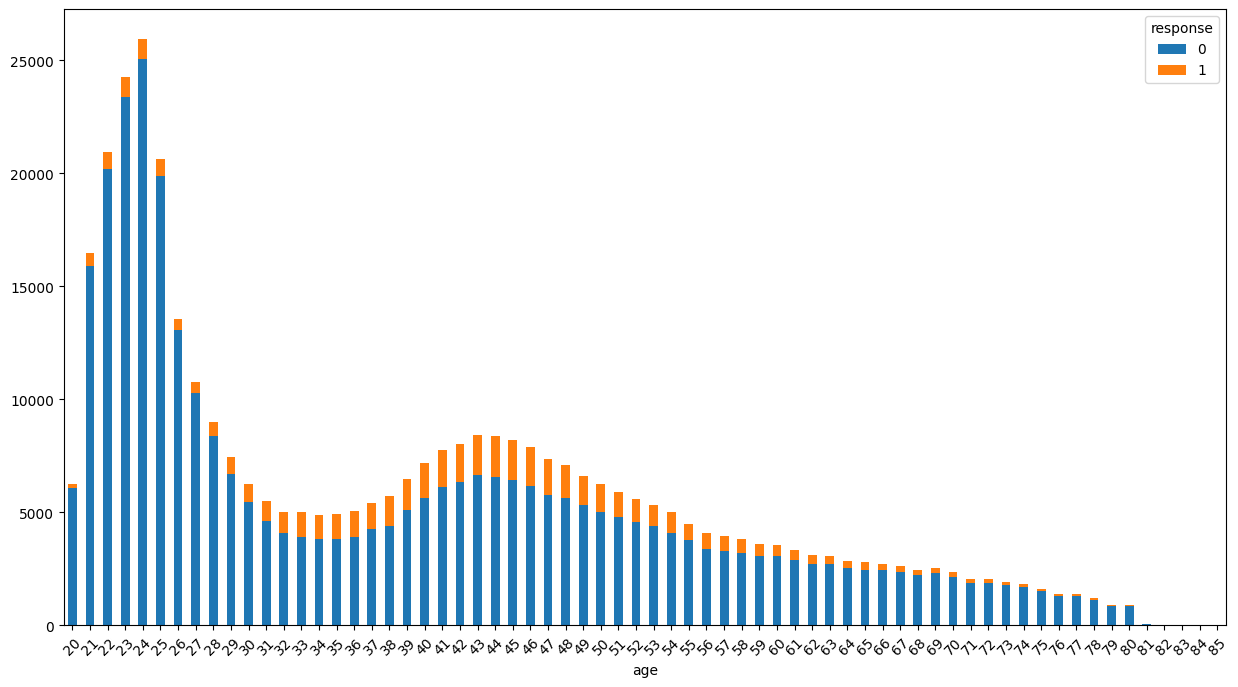

In [22]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['age'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)
plt.xticks(rotation=45);

### **4.2.4 Region_code**

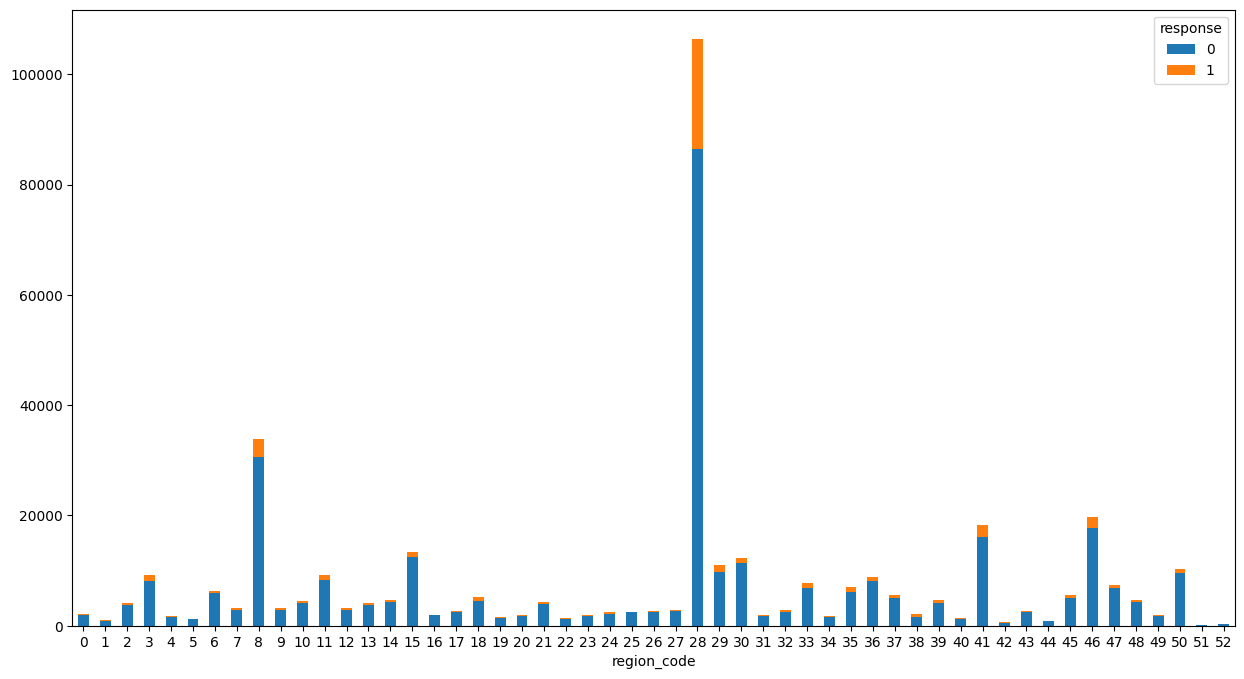

In [23]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['region_code'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

### **4.2.5 Policy_sales_channel**

In [25]:
df4['policy_sales_channel'].value_counts(ascending=True).head(20)

policy_sales_channel
41     1
144    1
143    1
123    1
43     1
149    1
84     1
112    2
75     2
50     2
74     2
34     3
28     3
105    3
27     3
33     3
6      3
102    3
76     4
68     4
Name: count, dtype: int64

In [26]:
aux=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') >20]
aux=aux[['policy_sales_channel','response']].groupby(['policy_sales_channel']).value_counts(normalize=True).reset_index()

aux1=aux[(aux['response']==1) & (aux['proportion']<=0.10)] 
aux2=aux[(aux['response']==1) & (aux['proportion']> 0.10) & (aux['proportion']<= 0.20)] 
aux3=aux[(aux['response']==1) & (aux['proportion']>0.20)] 


print(len(aux1))
print(len(aux2))
print(len(aux3))

36
42
16


In [27]:
df=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') <=50]

df1=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') >50]
df1=df1[df1.groupby('policy_sales_channel').policy_sales_channel.transform('count') <=100]

df2=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') >100]
df2=df2[df2.groupby('policy_sales_channel').policy_sales_channel.transform('count') <=1000]

df3=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') >1000]

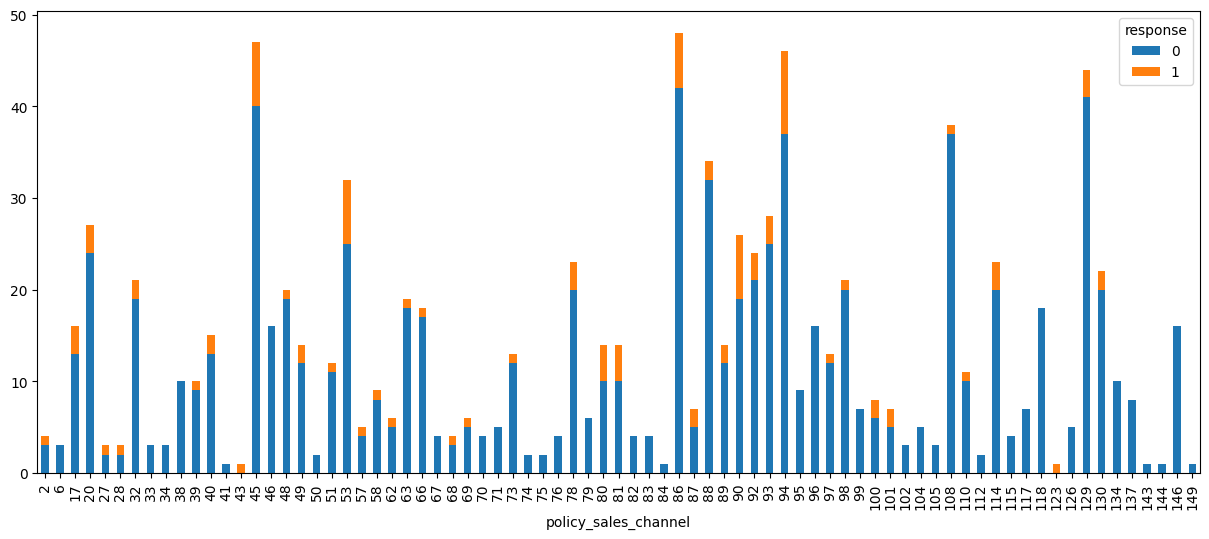

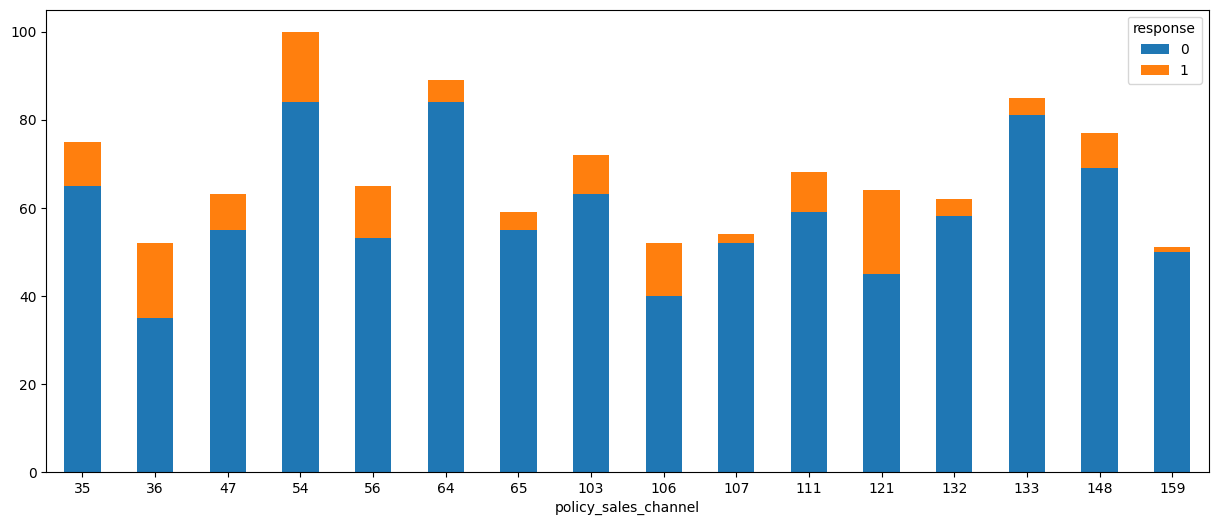

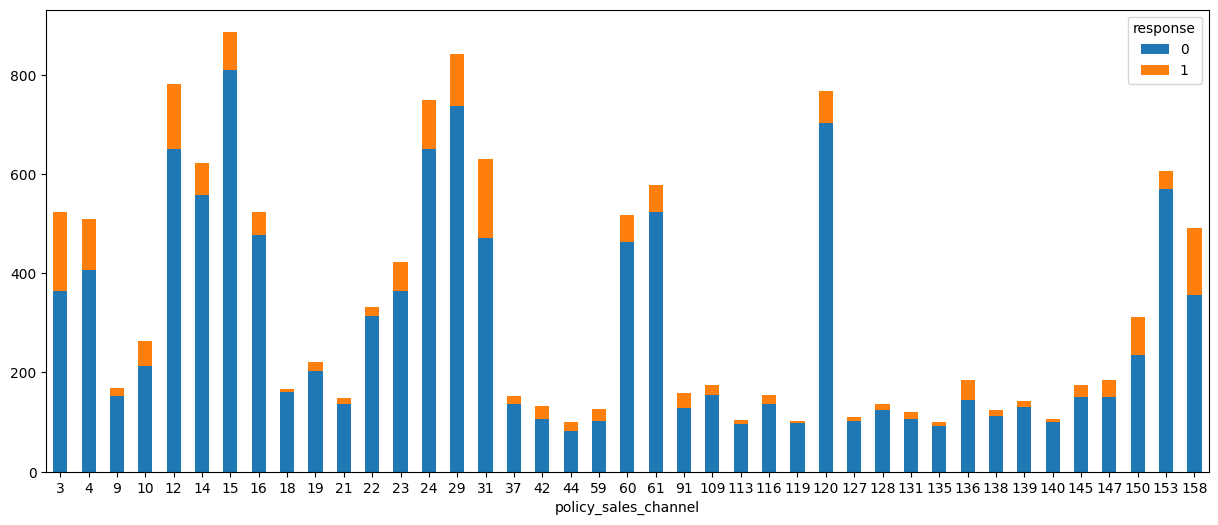

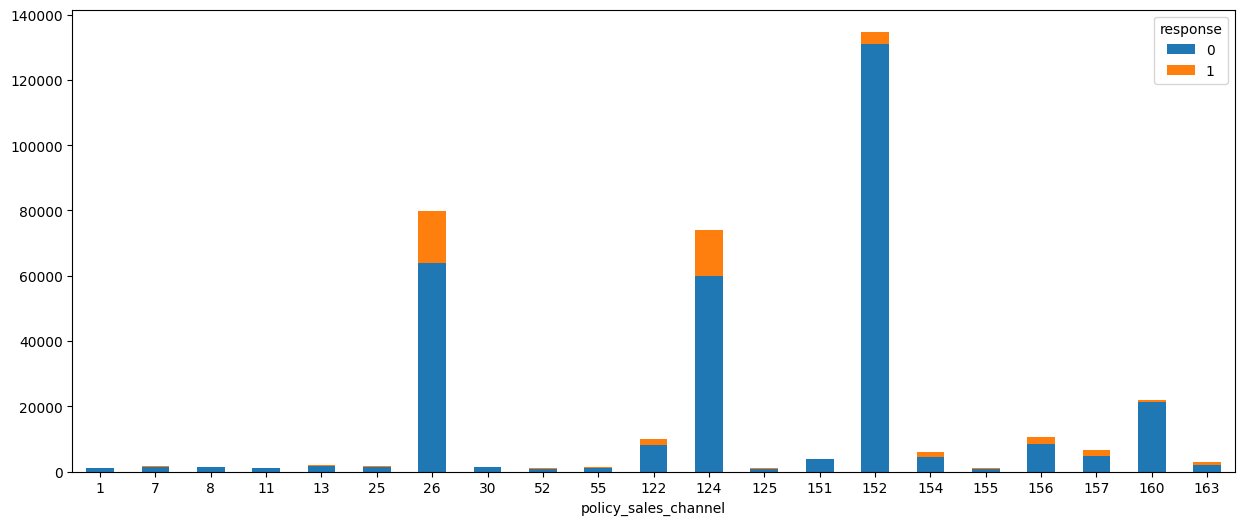

In [28]:
rcParams['figure.figsize'] = 15,6


crosstb=pd.crosstab(df['policy_sales_channel'],df['response'])
pl = crosstb.plot(kind="bar", stacked=True)
plt.xticks(rotation=90);


crosstb=pd.crosstab(df1['policy_sales_channel'],df1['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

crosstb1=pd.crosstab(df2['policy_sales_channel'],df2['response'])
pl = crosstb1.plot(kind="bar", stacked=True, rot=0)


crosstb2=pd.crosstab(df3['policy_sales_channel'],df3['response'])
pl = crosstb2.plot(kind="bar", stacked=True, rot=0)

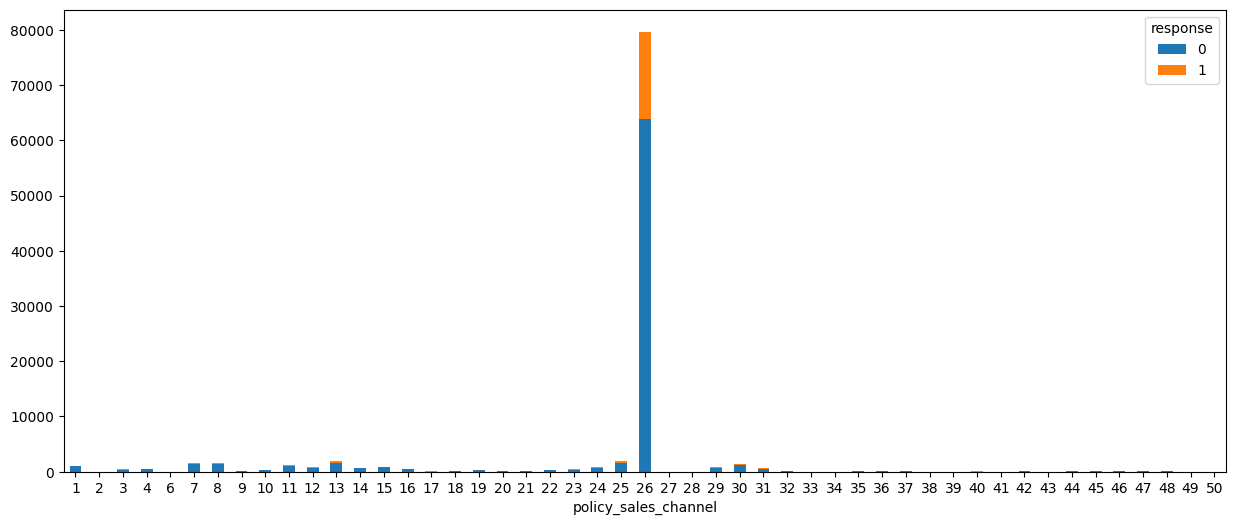

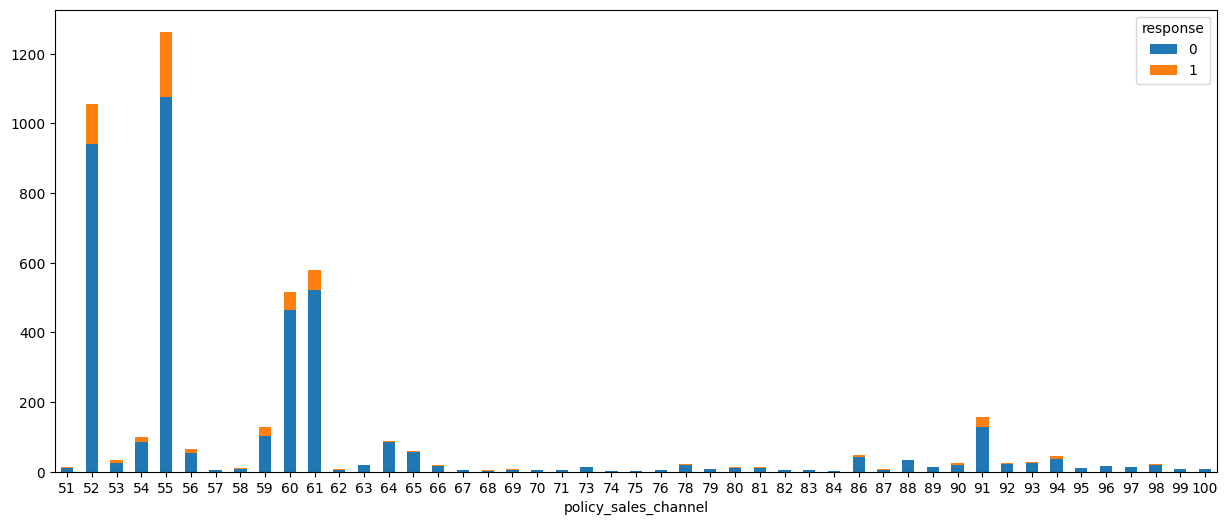

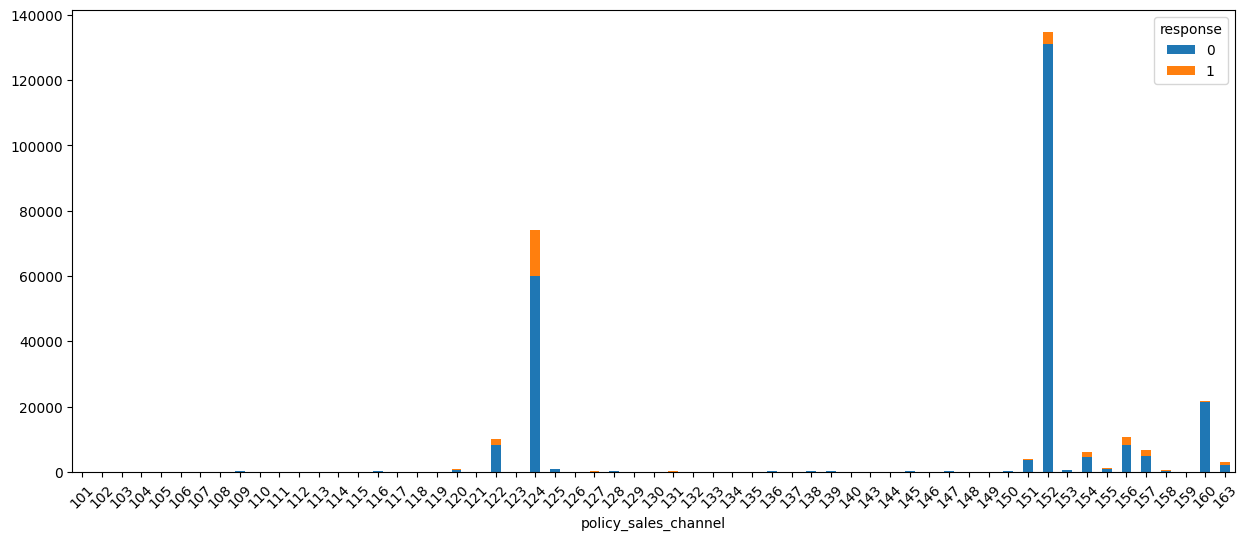

In [29]:
rcParams['figure.figsize'] = 15,6


aux=df4[df4['policy_sales_channel']<=50]
crosstb=pd.crosstab(aux['policy_sales_channel'],aux['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

aux1=df4[(df4['policy_sales_channel']>50) & (df4['policy_sales_channel']<=100)]
crosstb1=pd.crosstab(aux1['policy_sales_channel'],aux1['response'])
pl = crosstb1.plot(kind="bar", stacked=True, rot=0)


aux2=df4[df4['policy_sales_channel']>100]
crosstb2=pd.crosstab(aux2['policy_sales_channel'],aux2['response'])
pl = crosstb2.plot(kind="bar", stacked=True, rot=0)
plt.xticks(rotation=45);

In [30]:
aux=df4[['policy_sales_channel','response']].groupby(['policy_sales_channel']).count().reset_index()
# aux1=aux[aux['response']>10]
aux.head(26)

,policy_sales_channel,response
0,1,1074
1,2,4
2,3,523
3,4,509
4,6,3
5,7,1598
6,8,1515
7,9,169
8,10,264
9,11,1203


### **4.2.6 Vehicle_age**

In [31]:
df4[['vehicle_age','response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


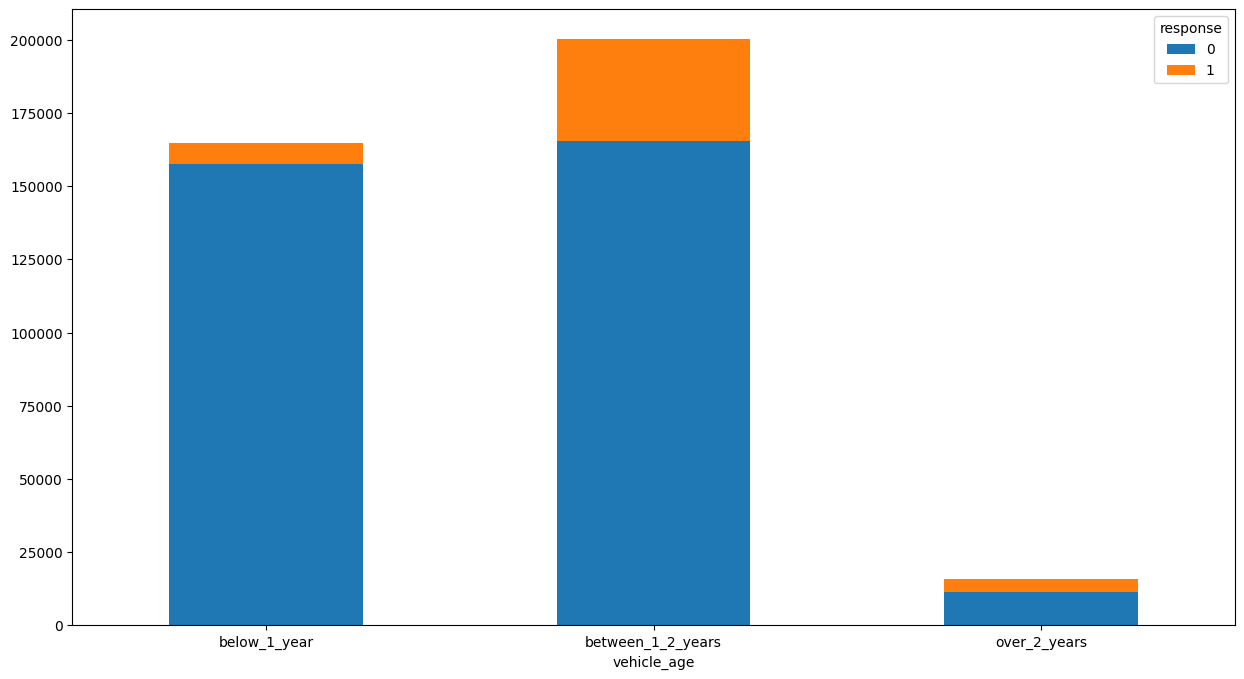

In [32]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['vehicle_age'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

### **4.2.7 Vehicle_damage**

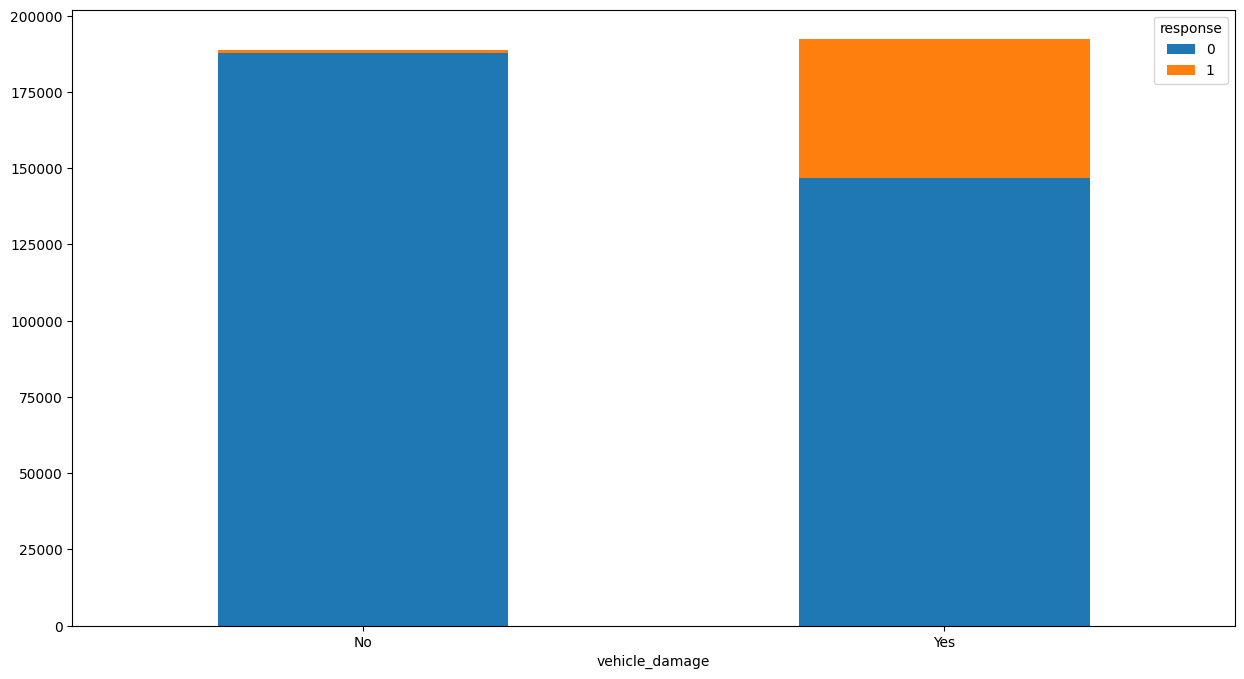

In [33]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['vehicle_damage'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

### **4.2.8 Previously_insured**

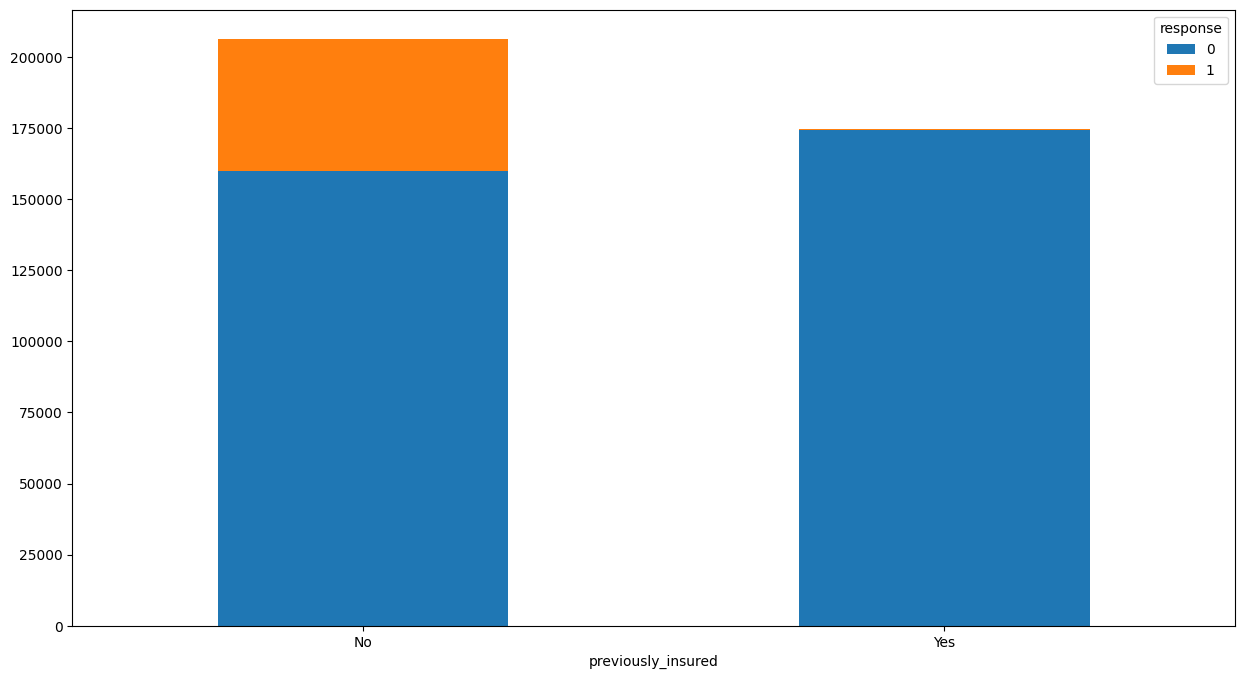

In [34]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['previously_insured'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [35]:
pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
previously_insured,,
No,0.774546,0.225454
Yes,0.999095,0.000905


### **4.2.9 Driving_license**

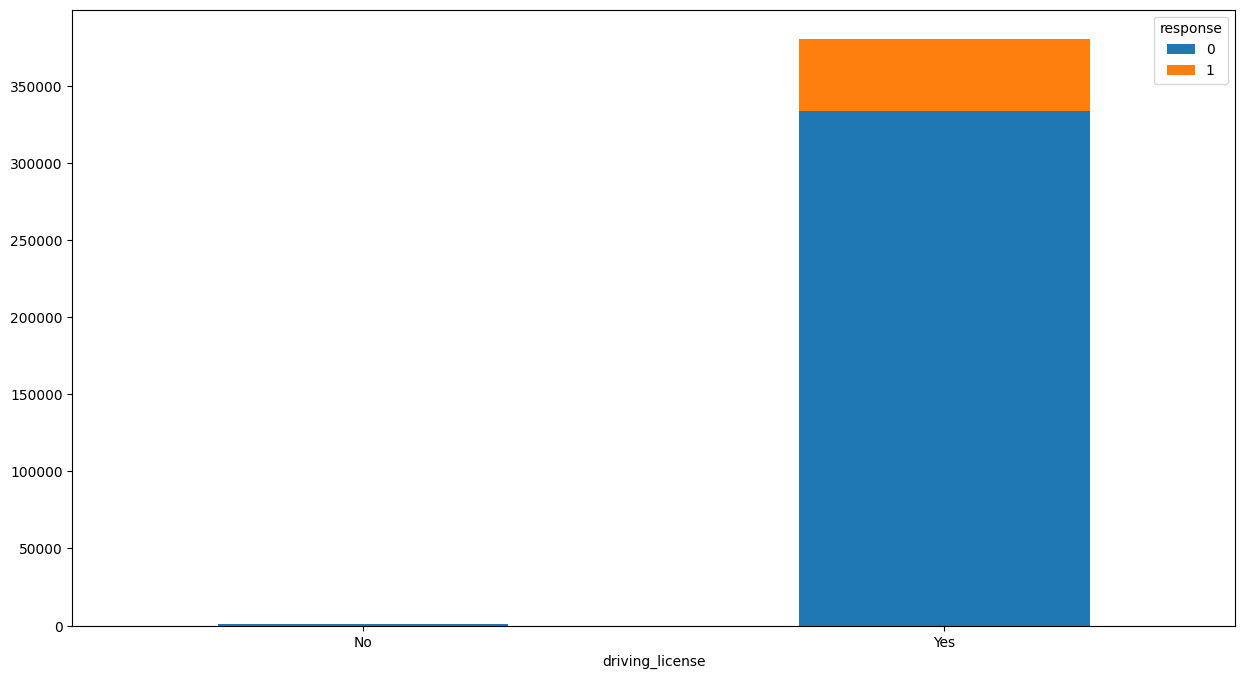

In [36]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['driving_license'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [37]:
pd.crosstab(df4['driving_license'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
driving_license,,
No,0.949507,0.050493
Yes,0.877283,0.122717


### 4.2.10 Gender

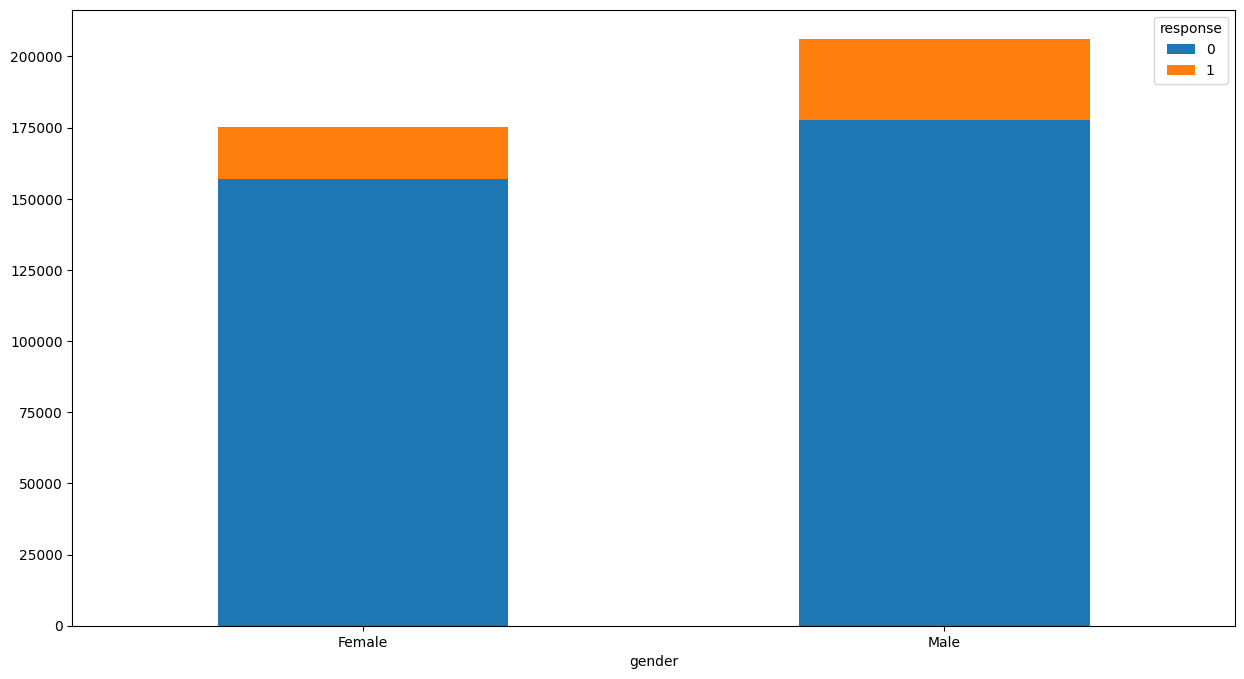

In [38]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['gender'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [39]:
pd.crosstab(df4['gender'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
gender,,
Female,0.896098,0.103902
Male,0.861589,0.138411


## **4.3 Multivariate analysis**

### **4.3.1 Numerical attributes**

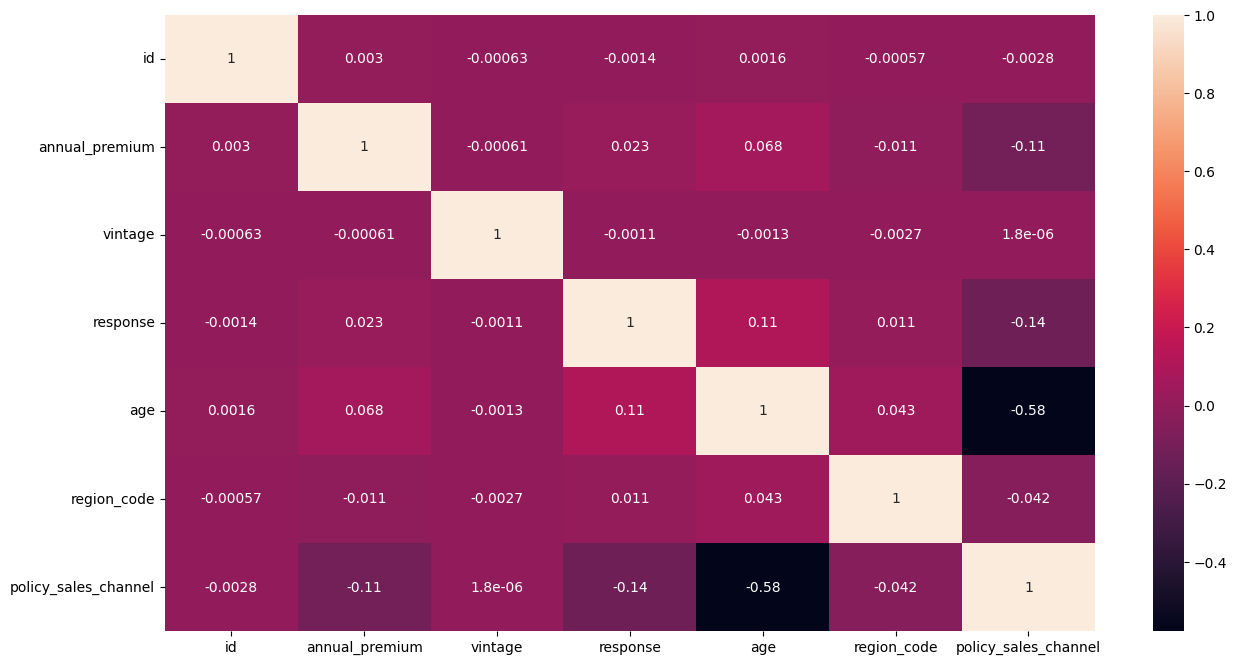

In [40]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### **4.3.2 Categorical attributes**

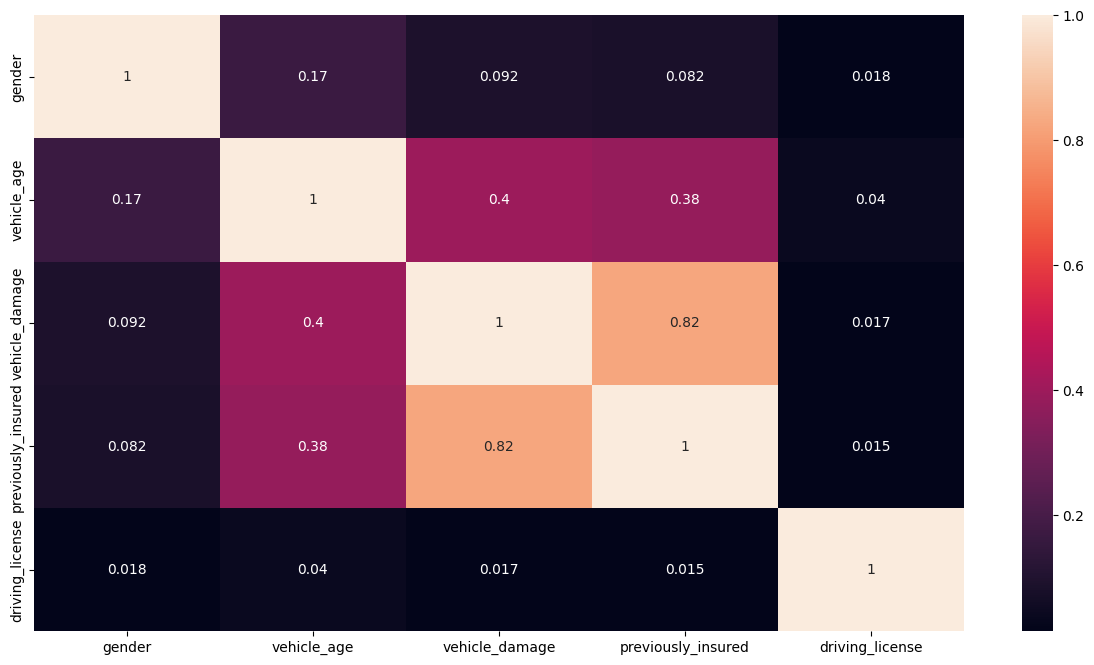

In [41]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['gender'], a['vehicle_damage'] )
a4 = cramer_v( a['gender'], a['previously_insured'] )
a5 = cramer_v( a['gender'], a['driving_license'] )

a6 = cramer_v( a['vehicle_age'], a['gender'] )
a7 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a8 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )
a9 = cramer_v( a['vehicle_age'], a['previously_insured'] )
a10 = cramer_v( a['vehicle_age'], a['driving_license'] )

a11 = cramer_v( a['vehicle_damage'], a['gender'] )
a12 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a13 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )
a14 = cramer_v( a['vehicle_damage'], a['previously_insured'] )
a15 = cramer_v( a['vehicle_damage'], a['driving_license'] )

a16 = cramer_v( a['previously_insured'], a['gender'] )
a17 = cramer_v( a['previously_insured'], a['vehicle_age'] )
a18 = cramer_v( a['previously_insured'], a['vehicle_damage'] )
a19 = cramer_v( a['previously_insured'], a['previously_insured'] )
a20 = cramer_v( a['previously_insured'], a['driving_license'] )

a21 = cramer_v( a['driving_license'], a['gender'] )
a22 = cramer_v( a['driving_license'], a['vehicle_age'] )
a23 = cramer_v( a['driving_license'], a['vehicle_damage'] )
a24 = cramer_v( a['driving_license'], a['previously_insured'] )
a25 = cramer_v( a['driving_license'], a['driving_license'] )

# Final dataset
d = pd.DataFrame( {'gender':          [a1, a2, a3, a4, a5], 
                   'vehicle_age':     [a6, a7, a8, a9, a10],
                   'vehicle_damage':  [a11, a12, a13, a14, a15],  
                'previously_insured': [a16, a17, a18, a19, a20],
                   'driving_license': [a21, a22, a23, a24, a25]})

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

## 4.4 Most important insights

- Only 12% are interested in car insurance

- People between 30-50 years old are more propense 

- One specific region have more people interested 

- A few sales channels are more effective

- Owners of vehicles between 1-2 years old are more likely to hire insurance

- Owners of vehicles with damages in the past are more likely to hire insurance  


# **5 Data preparation**

In [79]:
df5=df4.copy()

### 5.0.1 Numerical plots

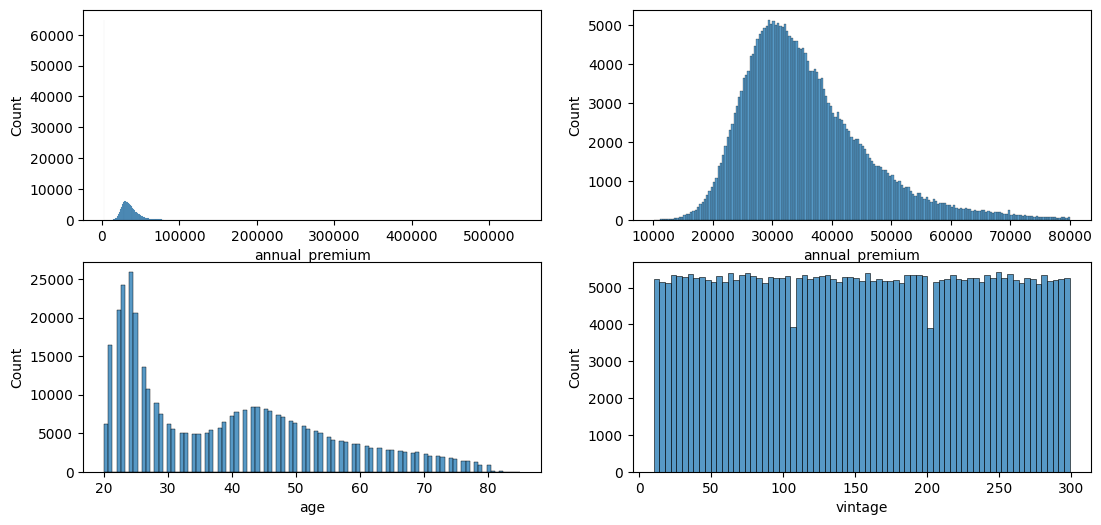

In [80]:
rcParams['figure.figsize'] = 13,6

plt.subplot(2,2,1)
sns.histplot(df5['annual_premium']);

plt.subplot(2,2,2)
aux=df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00=aux.loc[df4['response']==0,'annual_premium']        
sns.histplot(aux00);

plt.subplot(2,2,3)
sns.histplot(df5['age']); 

plt.subplot(2,2,4)
sns.histplot(df5['vintage']);

### 5.0.2 Train, validation and test separation

In [81]:
x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df5, 
                                                        target = 'response', 
                                                        train_size=0.8, valid_size=0.1, test_size=0.1,
                                                        random_state=42)

df5=pd.concat ([x_train, y_train], axis=1) 

## **5.1 Standardization**

In [82]:
# ANNUAL_PREMIUM
ss=pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values) 
# pickle.dump( ss, open( '../parameters/annual_premium_scaler.pkl', 'wb' ) )

x_val['annual_premium']=ss.transform(x_val[['annual_premium']].values)

x_test['annual_premium'] = ss.transform(x_test[['annual_premium']].values)

## **5.2 Rescaling**

In [83]:
# AGE
mms_age=pp.MinMaxScaler()

df5['age']=mms_age.fit_transform(df5[['age']].values)
# pickle.dump( mms_age, open( '../parameters/age_scaler.pkl', 'wb' ) )

x_val['age']=mms_age.transform(x_val[['age']].values)

x_test['age']=mms_age.transform(x_test[['age']].values)

# VINTAGE
mms_vintage=pp.MinMaxScaler()

df5['vintage']=mms_vintage.fit_transform(df5[['vintage']].values)
# pickle.dump( mms_vintage, open( '../parameters/vintage_scaler.pkl', 'wb' ) )

x_val['vintage']=mms_vintage.transform(x_val[['vintage']].values)

x_test['vintage']=mms_vintage.transform(x_test[['vintage']].values)

## **5.3 Encoder**

In [84]:
# GENDER
df5=pd.get_dummies(df5,prefix='gender',columns=['gender'])

x_val=pd.get_dummies(x_val,prefix='gender',columns=['gender'])

x_test=pd.get_dummies(x_test,prefix='gender',columns=['gender'])


# REGION_CODE
target_encode_region_code=df5.groupby('region_code')['response'].mean()
df5['region_code']=df5['region_code'].map(target_encode_region_code) 
# pickle.dump( target_encode_region_code, open( '../parameters/target_encode_region_code_scaler.pkl', 'wb' ) )

# target_encode_region_code=x_val.groupby('region_code')['response'].mean()
x_val['region_code']=x_val['region_code'].map(target_encode_region_code) 

# target_encode_region_code=x_test.groupby('region_code')['response'].mean()
x_test['region_code']=x_test['region_code'].map(target_encode_region_code)  


# VEHICLE_AGE
df5=pd.get_dummies(df5,prefix='vehicle_age',columns=['vehicle_age'])

x_val=pd.get_dummies(x_val,prefix='vehicle_age',columns=['vehicle_age'])

x_test=pd.get_dummies(x_test,prefix='vehicle_age',columns=['vehicle_age'])


# POLICY_SALES_CHANNEL
fe_policy_sales_channel=df5.groupby('policy_sales_channel').size()/len(df5)  
df5['policy_sales_channel']=df5['policy_sales_channel'].map(fe_policy_sales_channel)
# pickle.dump( fe_policy_sales_channel, open( '../parameters/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

# fe_policy_sales_channel=x_val.groupby('policy_sales_channel').size()/len(x_val)  
x_val['policy_sales_channel']=x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# fe_policy_sales_channel=x_test.groupby('policy_sales_channel').size()/len(x_test) 
x_test['policy_sales_channel']=x_test['policy_sales_channel'].map(fe_policy_sales_channel)


# PREVIOUSLY_INSURED
df5['previously_insured']=df5['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)

x_val['previously_insured']=x_val['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)

x_test['previously_insured']=x_test['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)


# DRIVING_LICENSE
df5['driving_license']=df5['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)

x_val['driving_license']=x_val['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)

x_test['driving_license']=x_test['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)

# VEHICLE_DAMAGE
df5['vehicle_damage']=df5['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

x_val['vehicle_damage']=x_val['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

x_test['vehicle_damage']=x_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# FILL NA
x_val=x_val.fillna(0)

X_test=x_test.fillna(0)

# **6 Feature selection**

In [85]:
df6=df5.copy()

## **6.1 Feature importance**

In [23]:
# model definition
forest=en.ExtraTreesClassifier(n_estimators=250,random_state=0,n_jobs=-1) 

# data preparation
x_train_n=df6.drop(['id','response'],axis=1)
y_train_n=y_train.values
forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking
                         feature  importance
0                        vintage    0.272644
0                 annual_premium    0.244569
0                            age    0.167744
0                    region_code    0.106285
0                 vehicle_damage    0.073512
0           policy_sales_channel    0.061830
0             previously_insured    0.049459
0       vehicle_age_below_1_year    0.012883
0  vehicle_age_between_1_2_years    0.006383
0       vehicle_age_over_2_years    0.002438
0                  gender_Female    0.000888
0                    gender_Male    0.000886
0                driving_license    0.000479


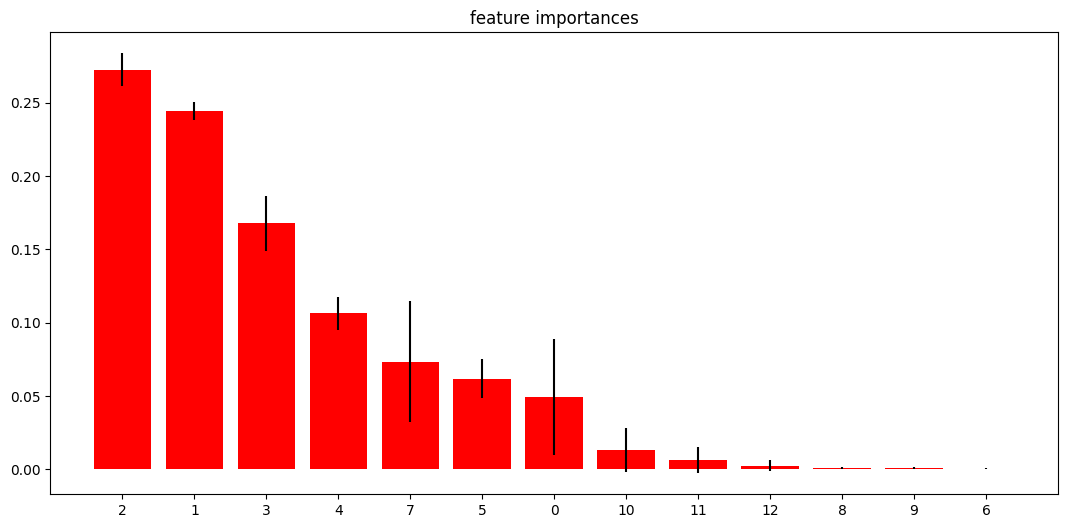

In [24]:
importances=forest.feature_importances_
std=np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices=np.argsort(importances)[::-1]  

# print the feature ranking
print('Feature ranking')
df=pd.DataFrame()
for i, j in zip(x_train_n,forest.feature_importances_): 
    aux=pd.DataFrame({'feature':i,'importance':j},index=[0])
    df=pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

# plot the imputiry-based feature importances of the forest
plt.figure()
plt.title('feature importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

# **7 Machine learning**

In [90]:
df7=df6.copy()

In [91]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df7[cols_selected]
x_val = x_val[cols_selected]
x_test = x_test[cols_selected]

## **7.1 Logistic regression**

Precision at 20% 0.3005378459923915 

Precision at 50% 0.2484256926952141 

Recall at 20% 0.47759016051698977 

Recall at 50% 0.9868667917448405 



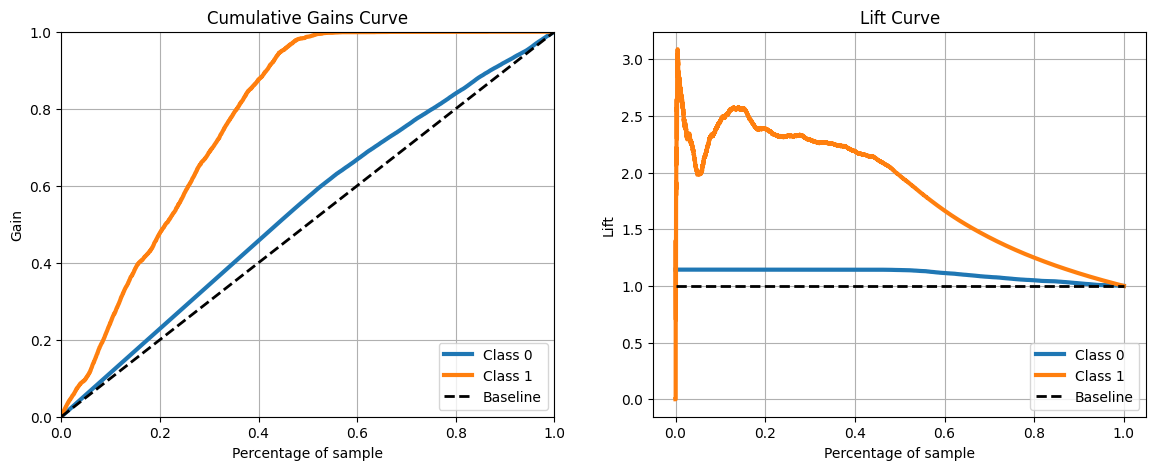

In [58]:
# model definition
lr=lm.LogisticRegression(random_state=42)

# model training
lr.fit(x_train,y_train)

# model prediction
yhat_lr=lr.predict_proba(x_val);


df = x_val.copy()
df['response'] = y_val.copy()

# propensity score
df['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values('score', ascending=False)

# compute precision at k 
precision_at_20_lr, data = precision_at_k(df, k=7622)
precision_at_50_lr, data = precision_at_k(df, k=19055)
print(f'Precision at 20% {precision_at_20_lr}','\n')
print(f'Precision at 50% {precision_at_50_lr}','\n')

# compute recall at k
recall_at_20_lr, data = recall_at_k(df, k=7622)
recall_at_50_lr, data = recall_at_k(df, k=19055)
print(f'Recall at 20% {recall_at_20_lr}','\n')
print(f'Recall at 50% {recall_at_50_lr}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lr,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lr,ax=ax2 );

### 7.1.1 Logistic regression - Cross validation

Precision at 20% 0.28945081254817073 

Precision at 50% 0.240526091377218 

Recall at 20% 0.47465512141339716 

Recall at 50% 0.9860166187108398 



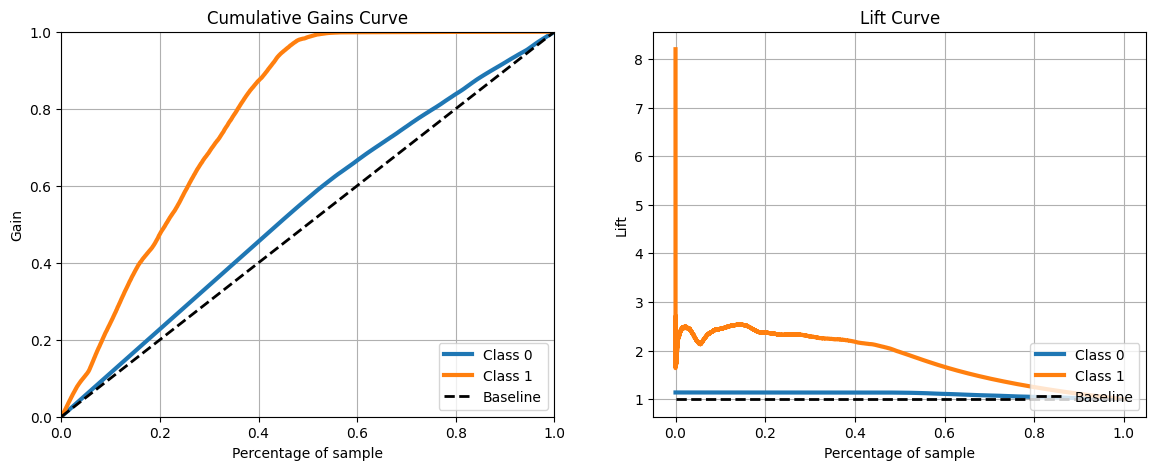

In [60]:
lr_cv = cross_val_predict(lr, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = lr_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values('score', ascending=False)

# compute precision at k 
precision_at_20_lrcv, data = precision_at_k(df, k=60980)
precision_at_50_lrcv, data = precision_at_k(df, k=152444)
print(f'Precision at 20% {precision_at_20_lrcv}','\n')
print(f'Precision at 50% {precision_at_50_lrcv}','\n')

# compute recall at k
recall_at_20_lrcv, data = recall_at_k(df, k=60980)
recall_at_50_lrcv, data = recall_at_k(df, k=152444)
print(f'Recall at 20% {recall_at_20_lrcv}','\n')
print(f'Recall at 50% {recall_at_50_lrcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,lr_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve(y_train, lr_cv,ax=ax2);

## **7.2 Knn**

Precision at 20% 0.3105076741440378 

Precision at 50% 0.20807094878253568 

Recall at 20% 0.49343339587242024 

Recall at 50% 0.8265582655826558 



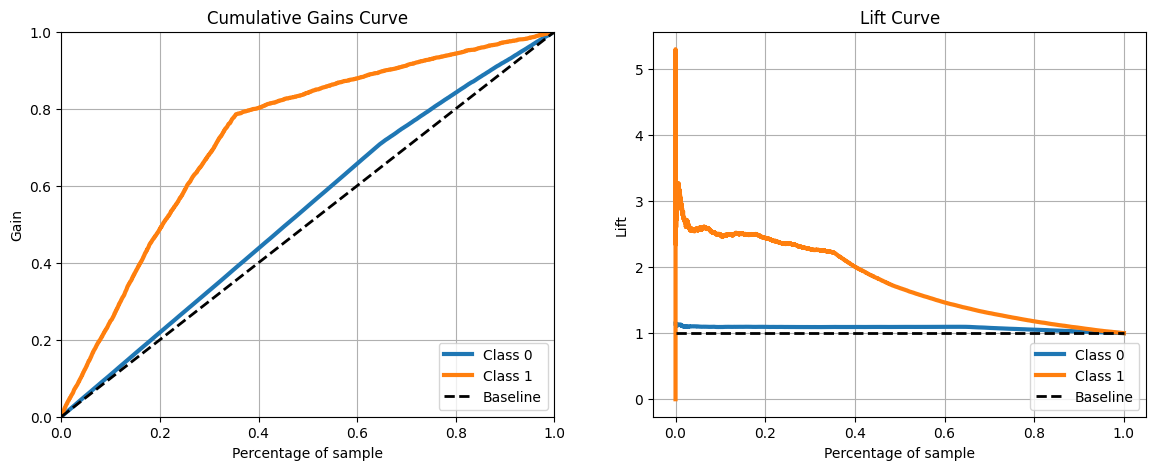

In [72]:
# model definition
knn=nh.KNeighborsClassifier(n_jobs=-1)

# model training
knn.fit(x_train,y_train)

# model prediction
yhat_knn=knn.predict_proba(x_val);


df = x_val.copy()
df['response'] = y_val.copy()

# propensity score
df['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values('score', ascending=False)

# compute precision at k 
precision_at_20_knn, data = precision_at_k(df, k=7622)
precision_at_50_knn, data = precision_at_k(df, k=19055)
print(f'Precision at 20% {precision_at_20_knn}','\n')
print(f'Precision at 50% {precision_at_50_knn}','\n')

# compute recall at k
recall_at_20_knn, data = recall_at_k(df, k=7622)
recall_at_50_knn, data = recall_at_k(df, k=19055)
print(f'Recall at 20% {recall_at_20_knn}','\n')
print(f'Recall at 50% {recall_at_50_knn}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve(y_val, yhat_knn,ax=ax2);

### 7.2.1 KNN - Cross validation

Precision at 20% 0.292041783506338 

Precision at 50% 0.20199416182885632 

Recall at 20% 0.47890391803587273 

Recall at 50% 0.8280581923790572 



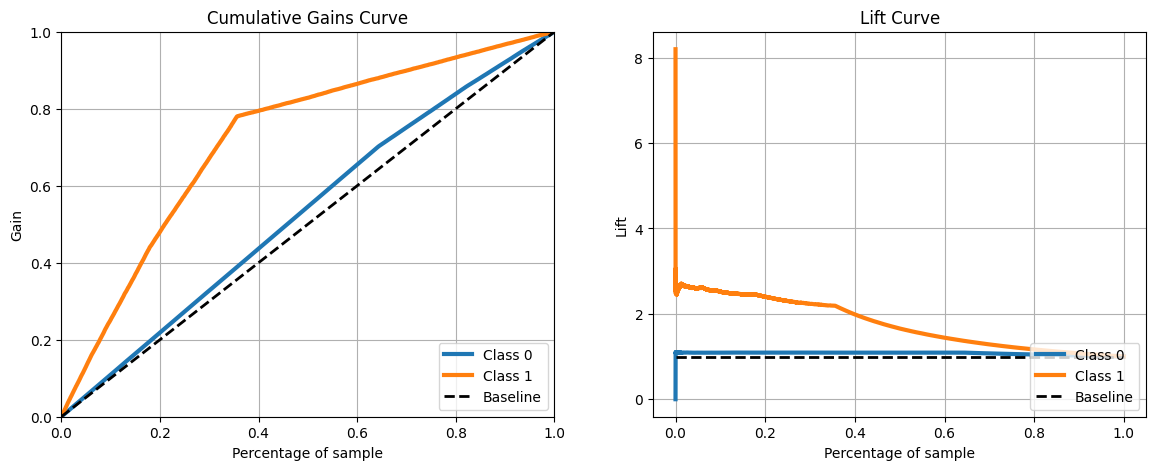

In [73]:
#
knn_cv = cross_val_predict(knn, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = knn_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_knncv, data = precision_at_k( df, k=60980 )
precision_at_50_knncv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_knncv}','\n')
print(f'Precision at 50% {precision_at_50_knncv}','\n')

# compute recall at k
recall_at_20_knncv, data = recall_at_k( df, k=60980 )
recall_at_50_knncv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_knncv}','\n')
print(f'Recall at 50% {recall_at_50_knncv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,knn_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, knn_cv,ax=ax2 );

## **7.3 Extra trees**

Precision at 20% 0.32729896366260003 

Precision at 50% 0.24643157010915198 

Recall at 20% 0.5201167396289348 

Recall at 50% 0.9789451740671253 



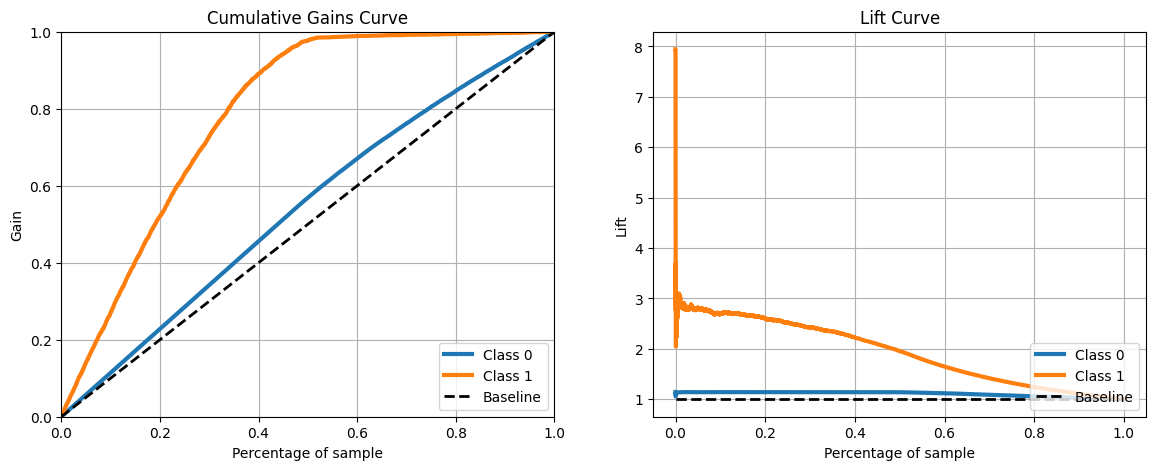

In [74]:
# model definition
et=en.ExtraTreesClassifier(n_jobs=-1,random_state=42)

# model training
et.fit(x_train,y_train)

# model prediction
yhat_et=et.predict_proba(x_val);


df = x_val.copy()
df['response'] = y_val.copy()

# propensity score
df['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_et, data = precision_at_k( df, k=7622 )
precision_at_50_et, data = precision_at_k( df, k=19055 )
print(f'Precision at 20% {precision_at_20_et}','\n')
print(f'Precision at 50% {precision_at_50_et}','\n')

# compute recall at k
recall_at_20_et, data = recall_at_k( df, k=7622 )
recall_at_50_et, data = recall_at_k( df, k=19055 )
print(f'Recall at 20% {recall_at_20_et}','\n')
print(f'Recall at 50% {recall_at_50_et}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_et,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_et,ax=ax2 );

### 7.3.1 Extra tress - Cross validation

Precision at 20% 0.30829274692117214 

Precision at 50% 0.23727245891961035 

Recall at 20% 0.5055530158388685 

Recall at 50% 0.9726786242504101 



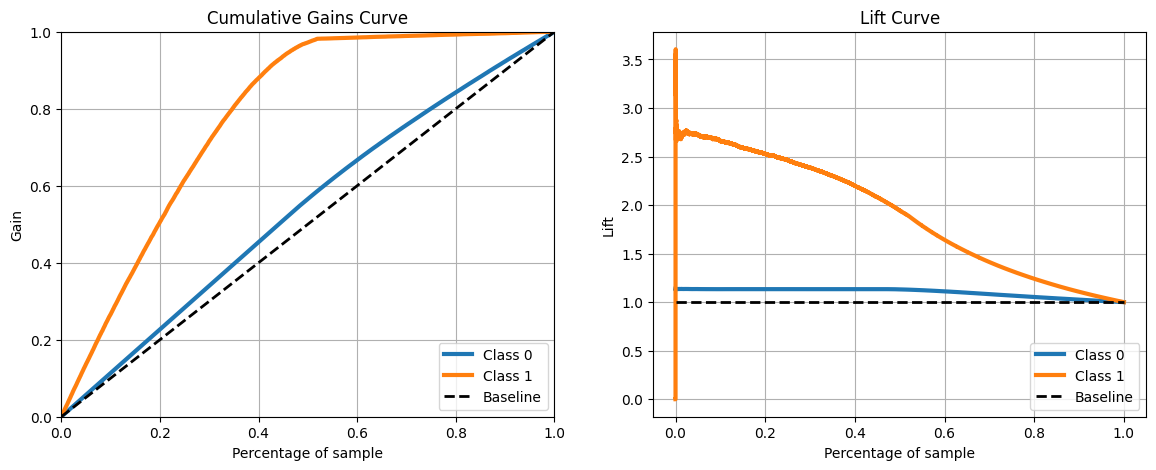

In [75]:
#
et_cv = cross_val_predict(et, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = et_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_etcv, data = precision_at_k( df, k=60980 )
precision_at_50_etcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_etcv}','\n')
print(f'Precision at 50% {precision_at_50_etcv}','\n')

# compute recall at k
recall_at_20_etcv, data = recall_at_k( df, k=60980 )
recall_at_50_etcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_etcv}','\n')
print(f'Recall at 50% {recall_at_50_etcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,et_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, et_cv,ax=ax2 );

## 7.4 Random forest

Precision at 20% 0.3351698806244261 

Precision at 50% 0.24711376994122586 

Recall at 20% 0.5326245570148009 

Recall at 50% 0.9816552011673962 



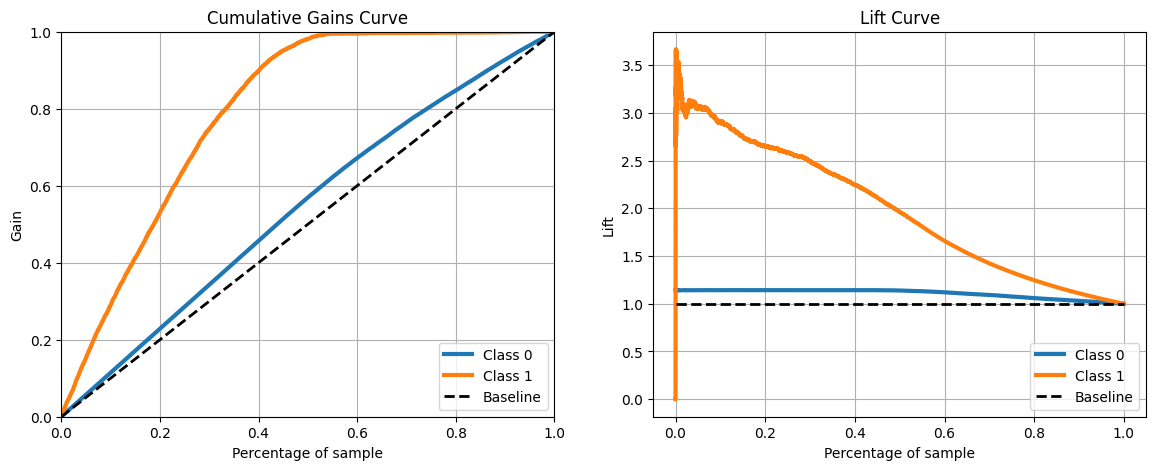

In [76]:
# model definition
rf = en.RandomForestClassifier(n_jobs=-1, random_state=42) 

# model training
rf.fit(x_train,y_train)

# model prediction
yhat_rf=rf.predict_proba(x_val);


df = x_val.copy()
df['response'] = y_val.copy()

# propensity score
df['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values('score', ascending=False)

# compute precision at k 
precision_at_20_rf, data = precision_at_k(df, k=7622)
precision_at_50_rf, data = precision_at_k(df, k=19055)
print(f'Precision at 20% {precision_at_20_rf}','\n')
print(f'Precision at 50% {precision_at_50_rf}','\n')

# compute recall at k
recall_at_20_rf, data = recall_at_k(df, k=7622)
recall_at_50_rf, data = recall_at_k(df, k=19055)
print(f'Recall at 20% {recall_at_20_rf}','\n')
print(f'Recall at 50% {recall_at_50_rf}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve(y_val, yhat_rf,ax=ax2);

### 7.4.1 Random forest - Cross validation

Precision at 20% 0.31408143520112825 

Precision at 50% 0.23920102331988585 

Recall at 20% 0.5150455804447791 

Recall at 50% 0.9805846129023583 



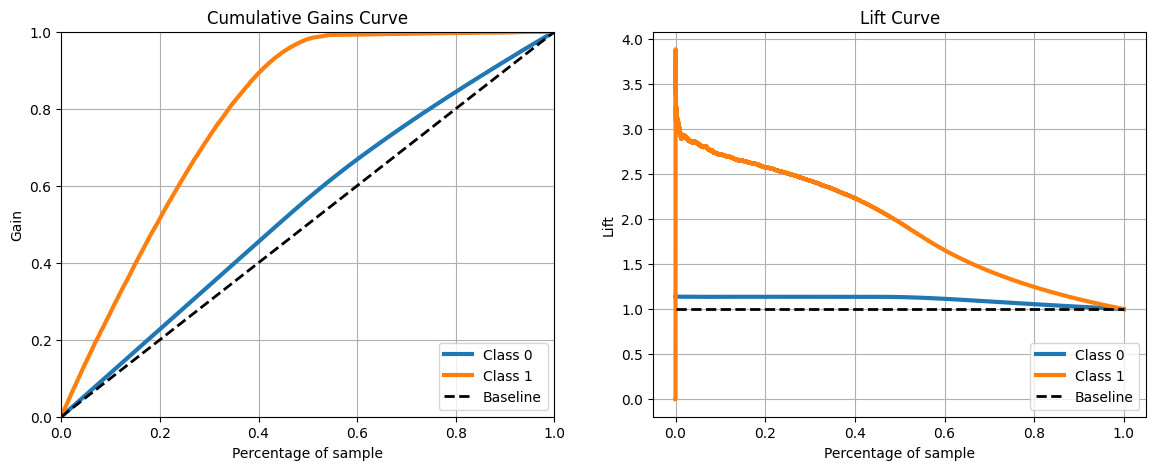

In [77]:
#
rf_cv = cross_val_predict(rf, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = rf_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_rfcv, data = precision_at_k( df, k=60980 )
precision_at_50_rfcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_rfcv}','\n')
print(f'Precision at 50% {precision_at_50_rfcv}','\n')

# compute recall at k
recall_at_20_rfcv, data = recall_at_k( df, k=60980 )
recall_at_50_rfcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_rfcv}','\n')
print(f'Recall at 50% {recall_at_50_rfcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,rf_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, rf_cv,ax=ax2 );

## **7.5 Xgb classifier**

Precision at 20% 0.36521054702872885 

Precision at 50% 0.2494752308984047 

Recall at 20% 0.5803627267041901 

Recall at 50% 0.9910360642067959 



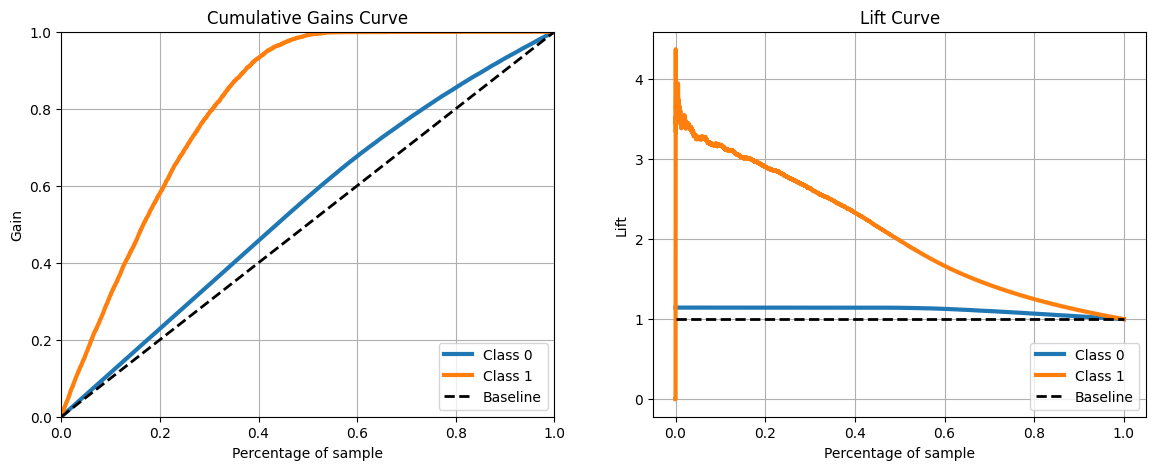

In [78]:
# model definition
xgb_model = xgb.XGBClassifier(n_jobs=-1, random_state=42) 

# model training
xgb_model.fit(x_train,y_train)

# model prediction
yhat_xgb=xgb_model.predict_proba(x_val);


df = x_val.copy()
df['response'] = y_val.copy()

# propensity score
df['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values('score', ascending=False)

# compute precision at k 
precision_at_20_xgb, data = precision_at_k(df, k=7622)
precision_at_50_xgb, data = precision_at_k(df, k=19055)
print(f'Precision at 20% {precision_at_20_xgb}','\n')
print(f'Precision at 50% {precision_at_50_xgb}','\n')

# compute recall at k
recall_at_20_xgb, data = recall_at_k( df, k=7622)
recall_at_50_xgb, data = recall_at_k( df, k=19055)
print(f'Recall at 20% {recall_at_20_xgb}','\n')
print(f'Recall at 50% {recall_at_50_xgb}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_xgb,ax=ax2 );

### **7.6.1 XGB Classifier - Cross validation**

Precision at 20% 0.34559944900870765 

Precision at 50% 0.2413526189773361 

Recall at 20% 0.5667303089789443 

Recall at 50% 0.9894048995616748 



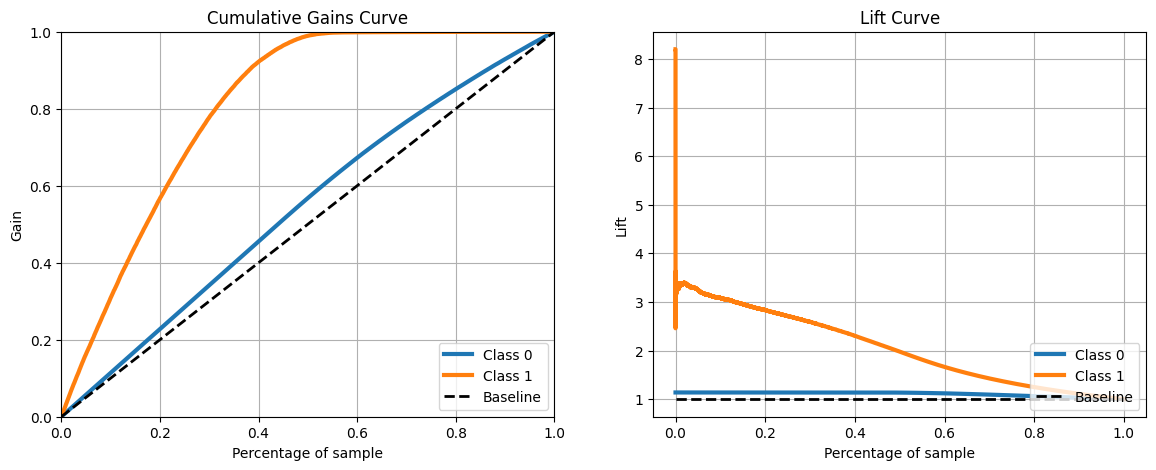

In [79]:
#
xgb_cv = cross_val_predict(xgb_model, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = xgb_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_xgbcv, data = precision_at_k( df, k=60980 )
precision_at_50_xgbcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_xgbcv}','\n')
print(f'Precision at 50% {precision_at_50_xgbcv}','\n')

# compute recall at k
recall_at_20_xgbcv, data = recall_at_k( df, k=60980 )
recall_at_50_xgbcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_xgbcv}','\n')
print(f'Recall at 50% {recall_at_50_xgbcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,xgb_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, xgb_cv,ax=ax2 );

## **7.6 Lgbm classifier**

Precision at 20% 0.3658664567755477 

Precision at 50% 0.2494752308984047 

Recall at 20% 0.5814050448196789 

Recall at 50% 0.9910360642067959 



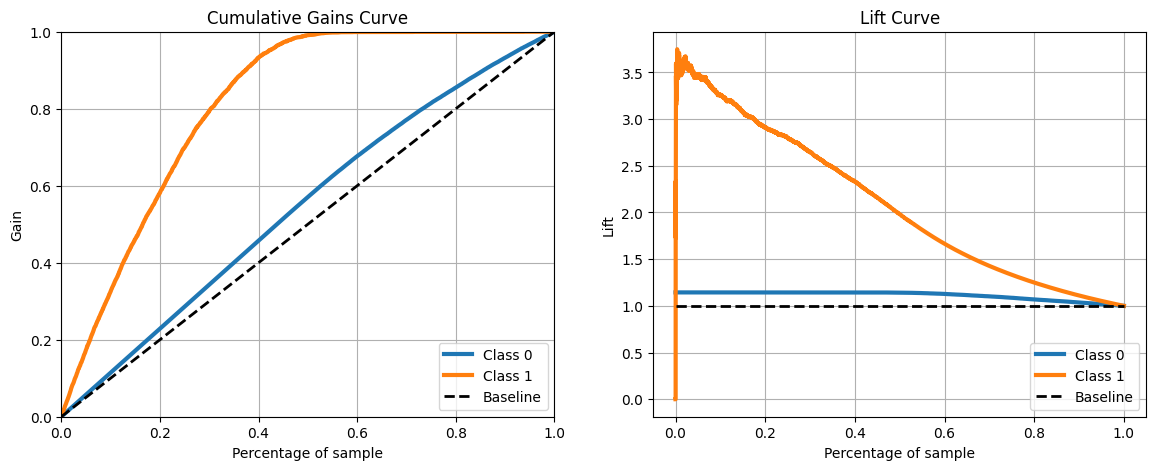

In [92]:
# model definition
lgbm = lightgbm.LGBMClassifier(n_jobs=-1,random_state=42) 

# model training
lgbm.fit(x_train,y_train)

# model prediction
yhat_lgbm=lgbm.predict_proba(x_val);


df = x_val.copy()
df['response'] = y_val.copy()

# propensity score
df['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values('score', ascending=False)

# compute precision at k 
precision_at_20_lgbm, data = precision_at_k(df, k=7622)
precision_at_50_lgbm, data = precision_at_k(df, k=19055)
print(f'Precision at 20% {precision_at_20_lgbm}','\n')
print(f'Precision at 50% {precision_at_50_lgbm}','\n')

# compute recall at k
recall_at_20_lgbm, data = recall_at_k(df, k=7622)
recall_at_50_lgbm, data = recall_at_k(df, k=19055)
print(f'Recall at 20% {recall_at_20_lgbm}','\n')
print(f'Recall at 50% {recall_at_50_lgbm}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lgbm,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm,ax=ax2 );

### **7.7.1 LGBM Classifier - Cross validation** 

Precision at 20% 0.3472229054951542 

Precision at 50% 0.24124110334874874 

Recall at 20% 0.5693925296474575 

Recall at 50% 0.9889477505579907 



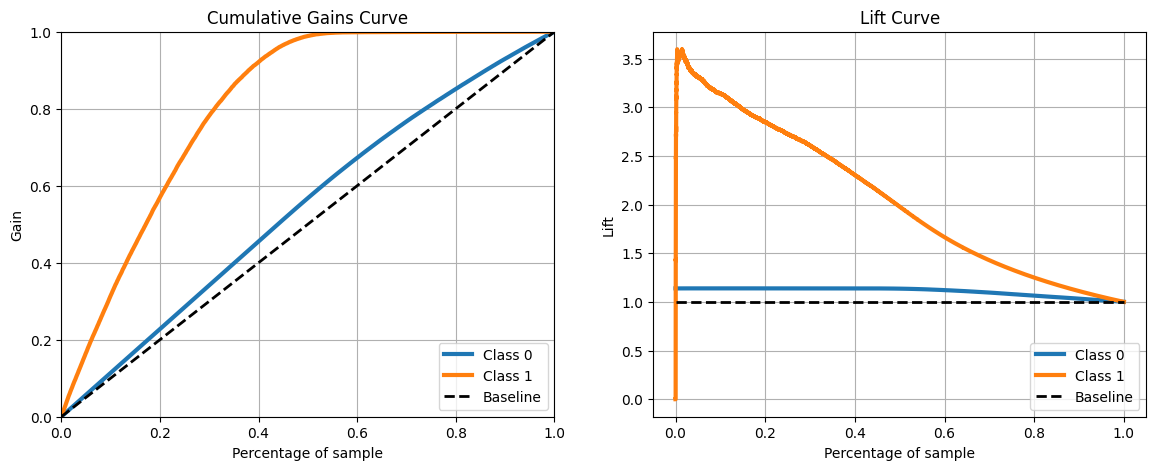

In [81]:
lgbm_cv = cross_val_predict(lgbm, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = lgbm_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_lgbmcv, data = precision_at_k( df, k=60980 )
precision_at_50_lgbmcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_lgbmcv}','\n')
print(f'Precision at 50% {precision_at_50_lgbmcv}','\n')

# compute recall at k
recall_at_20_lgbmcv, data = recall_at_k( df, k=60980 )
recall_at_50_lgbmcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_lgbmcv}','\n')
print(f'Recall at 50% {recall_at_50_lgbmcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,lgbm_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, lgbm_cv,ax=ax2 );

## 7.7 Compare performances

###  7.7.1 Cumulative gains curve

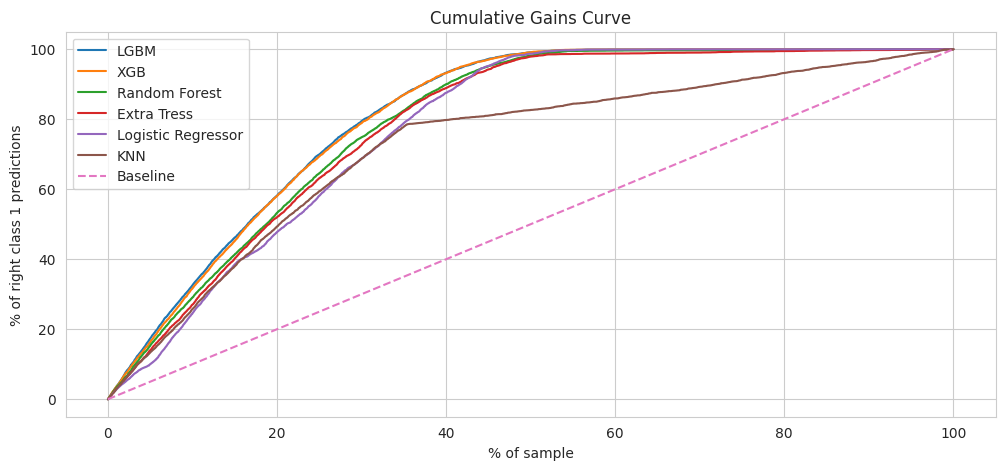

In [82]:
sns.set_style("whitegrid")

rcParams['figure.figsize'] = 12,5

grid=gridspec.GridSpec(1,1)
ax1 = plt.subplot(grid[0,0])


# LGBM
lgbm_results = pd.DataFrame()
lgbm_results['prediction'] = yhat_lgbm[:,1].tolist()
lgbm_results['real'] = y_val.tolist()

# ordering by prediction
lgbm_results = lgbm_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
lgbm_results['real_cum'] = lgbm_results['real'].cumsum() 
lgbm_results['real_cum_perc'] = 100*lgbm_results['real_cum']/lgbm_results['real'].sum()

# Percentage of Base ( Clients )
lgbm_results['base'] = range( 1, len( lgbm_results ) + 1  )
lgbm_results['base_cum_perc'] = 100*lgbm_results['base']/len( lgbm_results )

# Baseline model
lgbm_results['baseline'] = lgbm_results['base_cum_perc']

# Lift Calculation
lgbm_results['lift'] = lgbm_results['real_cum_perc'] / lgbm_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=lgbm_results,ax=ax1,label='LGBM')


# XGB
xgb_results = pd.DataFrame()
xgb_results['prediction'] = yhat_xgb[:,1].tolist()
xgb_results['real'] = y_val.tolist()

# ordering by prediction
xgb_results = xgb_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
xgb_results['real_cum'] = xgb_results['real'].cumsum() 
xgb_results['real_cum_perc'] = 100*xgb_results['real_cum']/xgb_results['real'].sum()

# Percentage of Base ( Clients )
xgb_results['base'] = range( 1, len( xgb_results ) + 1  )
xgb_results['base_cum_perc'] = 100*xgb_results['base']/len( xgb_results )

# Baseline model
xgb_results['baseline'] = xgb_results['base_cum_perc']

# Lift Calculation
xgb_results['lift'] = xgb_results['real_cum_perc'] / xgb_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=xgb_results,ax=ax1,label='XGB')


# RF
rf_results = pd.DataFrame()
rf_results['prediction'] = yhat_rf[:,1].tolist()
rf_results['real'] = y_val.tolist()

# ordering by prediction
rf_results = rf_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
rf_results['real_cum'] = rf_results['real'].cumsum() 
rf_results['real_cum_perc'] = 100*rf_results['real_cum']/rf_results['real'].sum()

# Percentage of Base ( Clients )
rf_results['base'] = range( 1, len( rf_results ) + 1  )
rf_results['base_cum_perc'] = 100*rf_results['base']/len( rf_results )

# Baseline model
rf_results['baseline'] = rf_results['base_cum_perc']

# Lift Calculation
rf_results['lift'] = rf_results['real_cum_perc'] / rf_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=rf_results,ax=ax1,label='Random Forest')


# ET
et_results = pd.DataFrame()
et_results['prediction'] = yhat_et[:,1].tolist()
et_results['real'] = y_val.tolist()

# ordering by prediction
et_results = et_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
et_results['real_cum'] = et_results['real'].cumsum() 
et_results['real_cum_perc'] = 100*et_results['real_cum']/et_results['real'].sum()

# Percentage of Base ( Clients )
et_results['base'] = range( 1, len( et_results ) + 1  )
et_results['base_cum_perc'] = 100*et_results['base']/len( et_results )

# Baseline model
et_results['baseline'] = et_results['base_cum_perc']

# Lift Calculation
et_results['lift'] = et_results['real_cum_perc'] / et_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=et_results,ax=ax1,label='Extra Tress')


# LR
lr_results = pd.DataFrame()
lr_results['prediction'] = yhat_lr[:,1].tolist()
lr_results['real'] = y_val.tolist()

# ordering by prediction
lr_results = lr_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
lr_results['real_cum'] = lr_results['real'].cumsum() 
lr_results['real_cum_perc'] = 100*lr_results['real_cum']/lr_results['real'].sum()

# Percentage of Base ( Clients )
lr_results['base'] = range( 1, len( lr_results ) + 1  )
lr_results['base_cum_perc'] = 100*lr_results['base']/len( lr_results )

# Baseline model
lr_results['baseline'] = lr_results['base_cum_perc']

# Lift Calculation
lr_results['lift'] = lr_results['real_cum_perc'] / lr_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=lr_results,ax=ax1,label='Logistic Regressor')


# KNN
knn_results = pd.DataFrame()
knn_results['prediction'] = yhat_knn[:,1].tolist()
knn_results['real'] = y_val.tolist()

# ordering by prediction
knn_results = knn_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
knn_results['real_cum'] = knn_results['real'].cumsum() 
knn_results['real_cum_perc'] = 100*knn_results['real_cum']/knn_results['real'].sum()

# Percentage of Base ( Clients )
knn_results['base'] = range( 1, len( knn_results ) + 1  )
knn_results['base_cum_perc'] = 100*knn_results['base']/len( knn_results )

# Baseline model
knn_results['baseline'] = knn_results['base_cum_perc']

# Lift Calculation
knn_results['lift'] = knn_results['real_cum_perc'] / knn_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=knn_results,ax=ax1,label='KNN')

sns.lineplot( x='base_cum_perc', y='baseline', data=lr_results,ax=ax1,label='Baseline',linestyle='--')


ax1.set_title('Cumulative Gains Curve')
ax1.set_xlabel('% of sample');
ax1.set_ylabel('% of right class 1 predictions');

###  7.7.2 Lift curve

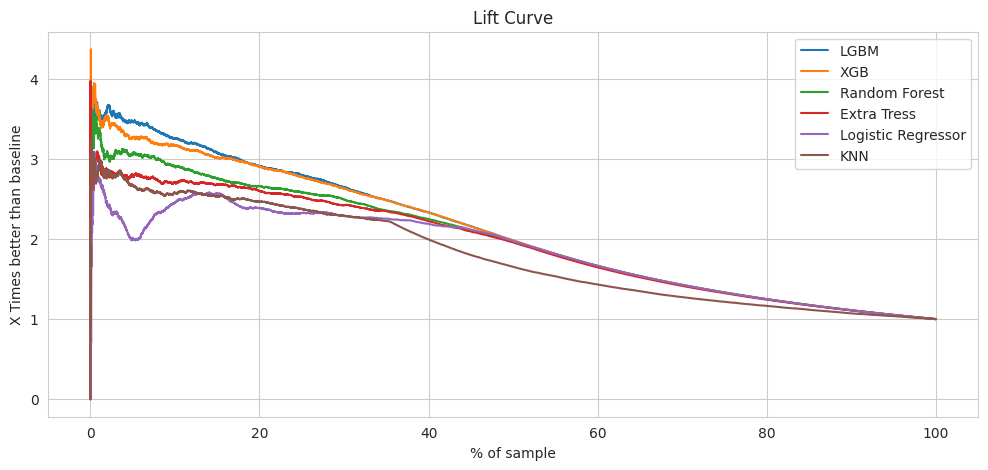

In [83]:
rcParams['figure.figsize'] = 12,5

grid=gridspec.GridSpec(1,1)

ax1 = plt.subplot(grid[0,0])

sns.lineplot( x='base_cum_perc', y='lift', data=lgbm_results,ax=ax1,label='LGBM' )

sns.lineplot( x='base_cum_perc', y='lift', data=xgb_results,ax=ax1,label='XGB' )

sns.lineplot( x='base_cum_perc', y='lift', data=rf_results,ax=ax1,label='Random Forest' )

sns.lineplot( x='base_cum_perc', y='lift', data=et_results,ax=ax1,label='Extra Tress' )

sns.lineplot( x='base_cum_perc', y='lift', data=lr_results,ax=ax1,label='Logistic Regressor' )

sns.lineplot( x='base_cum_perc', y='lift', data=knn_results,ax=ax1,label='KNN' )

ax1.set_title('Lift Curve')
ax1.set_xlabel('% of sample');
ax1.set_ylabel('X Times better than baseline');

###  7.7.3 Precision at k and recall at k

In [84]:
res=np.array([[precision_at_20_lgbm,precision_at_50_lgbm,recall_at_20_lgbm,recall_at_50_lgbm],
            [precision_at_20_xgb, precision_at_50_xgb, recall_at_20_xgb, recall_at_50_xgb],
            [precision_at_20_rf,  precision_at_50_rf,  recall_at_20_rf,  recall_at_50_rf],
            [precision_at_20_et,  precision_at_50_et,  recall_at_20_et,  recall_at_50_et],
            [precision_at_20_knn, precision_at_50_knn, recall_at_20_knn,  recall_at_50_knn],
            [precision_at_20_lr,  precision_at_50_lr,  recall_at_20_lr,  recall_at_50_lr]])

results=pd.DataFrame(res,columns=['precision_at_20','precision_at_50','recall_at_20','recall_at_50'],
                 index=['LGBM','XGB','RF','ET','KNN','LR'])

results

,precision_at_20,precision_at_50,recall_at_20,recall_at_50
LGBM,0.365866,0.249475,0.581405,0.991036
XGB,0.365211,0.249475,0.580363,0.991036
RF,0.335170,0.247114,0.532625,0.981655
ET,0.327299,0.246432,0.520117,0.978945
KNN,0.310508,0.208071,0.493433,0.826558
LR,0.300538,0.248426,0.477590,0.986867


In [85]:
print('Best precision at 20%:')
print(results['precision_at_20'].sort_values(ascending=False).to_string())

Best precision at 20%:
LGBM    0.365866
XGB     0.365211
RF      0.335170
ET      0.327299
KNN     0.310508
LR      0.300538


In [86]:
print('Best precision at 50%:')
print(results['precision_at_50'].sort_values(ascending=False).to_string())

Best precision at 50%:
LGBM    0.249475
XGB     0.249475
LR      0.248426
RF      0.247114
ET      0.246432
KNN     0.208071


In [87]:
print('Best recall at 20%:')
print(results['recall_at_20'].sort_values(ascending=False).to_string())

Best recall at 20%:
LGBM    0.581405
XGB     0.580363
RF      0.532625
ET      0.520117
KNN     0.493433
LR      0.477590


In [88]:
print('Best recall at 50%:')
print(results['recall_at_50'].sort_values(ascending=False).to_string())

Best recall at 50%:
LGBM    0.991036
XGB     0.991036
LR      0.986867
RF      0.981655
ET      0.978945
KNN     0.826558


## **7.8 Compare cross validation performances**

### 7.8.1 Cumulative gains curve

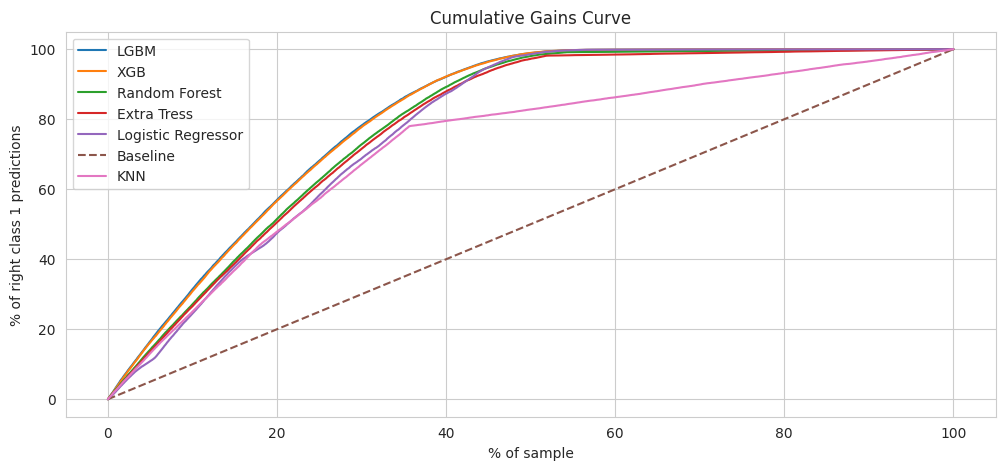

In [89]:
sns.set_style("whitegrid")
rcParams['figure.figsize'] = 12,5

grid=gridspec.GridSpec(1,1)
ax1 = plt.subplot(grid[0,0])


# LGBM
lgbm_results_cv = pd.DataFrame()
lgbm_results_cv['prediction'] = lgbm_cv[:,1].tolist()
lgbm_results_cv['real'] = y_train.tolist()

# ordering by prediction
lgbm_results_cv = lgbm_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
lgbm_results_cv['real_cum'] = lgbm_results_cv['real'].cumsum() 
lgbm_results_cv['real_cum_perc'] = 100*lgbm_results_cv['real_cum']/lgbm_results_cv['real'].sum()

# Percentage of Base ( Clients )
lgbm_results_cv['base'] = range( 1, len( lgbm_results_cv ) + 1  )
lgbm_results_cv['base_cum_perc'] = 100*lgbm_results_cv['base']/len( lgbm_results_cv )

# Baseline model
lgbm_results_cv['baseline'] = lgbm_results_cv['base_cum_perc']

# Lift Calculation
lgbm_results_cv['lift'] = lgbm_results_cv['real_cum_perc'] / lgbm_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=lgbm_results_cv,ax=ax1,label='LGBM')


# XGB
xgb_results_cv = pd.DataFrame()
xgb_results_cv['prediction'] = xgb_cv[:,1].tolist()
xgb_results_cv['real'] = y_train.tolist()

# ordering by prediction
xgb_results_cv = xgb_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
xgb_results_cv['real_cum'] = xgb_results_cv['real'].cumsum() 
xgb_results_cv['real_cum_perc'] = 100*xgb_results_cv['real_cum']/xgb_results_cv['real'].sum()

# Percentage of Base ( Clients )
xgb_results_cv['base'] = range( 1, len( xgb_results_cv ) + 1  )
xgb_results_cv['base_cum_perc'] = 100*xgb_results_cv['base']/len( xgb_results_cv )

# Baseline model
xgb_results_cv['baseline'] = xgb_results_cv['base_cum_perc']

# Lift Calculation
xgb_results_cv['lift'] = xgb_results_cv['real_cum_perc'] / xgb_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=xgb_results_cv,ax=ax1,label='XGB')


# RF
rf_results_cv = pd.DataFrame()
rf_results_cv['prediction'] = rf_cv[:,1].tolist()
rf_results_cv['real'] = y_train.tolist()

# ordering by prediction
rf_results_cv = rf_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
rf_results_cv['real_cum'] = rf_results_cv['real'].cumsum() 
rf_results_cv['real_cum_perc'] = 100*rf_results_cv['real_cum']/rf_results_cv['real'].sum()

# Percentage of Base ( Clients )
rf_results_cv['base'] = range( 1, len( rf_results_cv ) + 1  )
rf_results_cv['base_cum_perc'] = 100*rf_results_cv['base']/len( rf_results_cv )

# Baseline model
rf_results_cv['baseline'] = rf_results_cv['base_cum_perc']

# Lift Calculation
rf_results_cv['lift'] = rf_results_cv['real_cum_perc'] / rf_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=rf_results_cv,ax=ax1,label='Random Forest')


# ET
et_results_cv = pd.DataFrame()
et_results_cv['prediction'] = et_cv[:,1].tolist()
et_results_cv['real'] = y_train.tolist()

# ordering by prediction
et_results_cv = et_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
et_results_cv['real_cum'] = et_results_cv['real'].cumsum() 
et_results_cv['real_cum_perc'] = 100*et_results_cv['real_cum']/et_results_cv['real'].sum()

# Percentage of Base ( Clients )
et_results_cv['base'] = range( 1, len( et_results_cv ) + 1  )
et_results_cv['base_cum_perc'] = 100*et_results_cv['base']/len( et_results_cv )

# Baseline model
et_results_cv['baseline'] = et_results_cv['base_cum_perc']

# Lift Calculation
et_results_cv['lift'] = et_results_cv['real_cum_perc'] / et_results_cv['base_cum_perc']


sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=et_results_cv,ax=ax1,label='Extra Tress')


# LR
lr_results_cv = pd.DataFrame()
lr_results_cv['prediction'] = lr_cv[:,1].tolist()
lr_results_cv['real'] = y_train.tolist()

# ordering by prediction
lr_results_cv = lr_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
lr_results_cv['real_cum'] = lr_results_cv['real'].cumsum() 
lr_results_cv['real_cum_perc'] = 100*lr_results_cv['real_cum']/lr_results_cv['real'].sum()

# Percentage of Base ( Clients )
lr_results_cv['base'] = range( 1, len( lr_results_cv ) + 1  )
lr_results_cv['base_cum_perc'] = 100*lr_results_cv['base']/len( lr_results_cv )

# Baseline model
lr_results_cv['baseline'] = lr_results_cv['base_cum_perc']

# Lift Calculation
lr_results_cv['lift'] = lr_results_cv['real_cum_perc'] / lr_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=lr_results_cv,ax=ax1,label='Logistic Regressor')

sns.lineplot( x='base_cum_perc', y='baseline', data=lr_results_cv,ax=ax1,label='Baseline',linestyle='--')


# KNN
knn_results_cv = pd.DataFrame()
knn_results_cv['prediction'] = knn_cv[:,1].tolist()
knn_results_cv['real'] = y_train.tolist()

# ordering by prediction
knn_results_cv = knn_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
knn_results_cv['real_cum'] = knn_results_cv['real'].cumsum() 
knn_results_cv['real_cum_perc'] = 100*knn_results_cv['real_cum']/knn_results_cv['real'].sum()

# Percentage of Base ( Clients )
knn_results_cv['base'] = range( 1, len( knn_results_cv ) + 1  )
knn_results_cv['base_cum_perc'] = 100*knn_results_cv['base']/len( knn_results_cv )

# Baseline model
knn_results_cv['baseline'] = knn_results_cv['base_cum_perc']

# Lift Calculation
knn_results_cv['lift'] = knn_results_cv['real_cum_perc'] / knn_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=knn_results_cv,ax=ax1,label='KNN')

ax1.set_title('Cumulative Gains Curve')
ax1.set_xlabel('% of sample');
ax1.set_ylabel('% of right class 1 predictions');

### 7.8.2 Lift curve

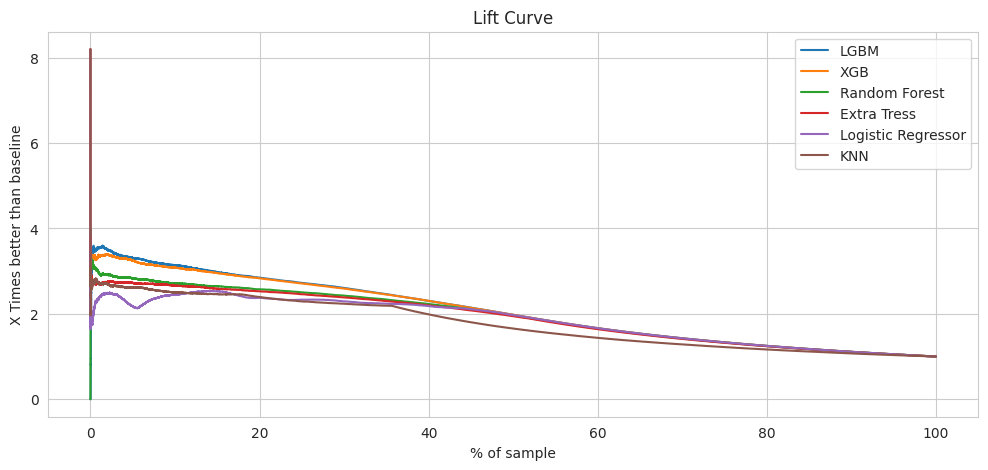

In [91]:
rcParams['figure.figsize'] = 12,5

grid=gridspec.GridSpec(1,1)

ax1 = plt.subplot(grid[0,0])

sns.lineplot( x='base_cum_perc', y='lift', data=lgbm_results_cv,ax=ax1,label='LGBM' )

sns.lineplot( x='base_cum_perc', y='lift', data=xgb_results_cv,ax=ax1,label='XGB' )

sns.lineplot( x='base_cum_perc', y='lift', data=rf_results_cv,ax=ax1,label='Random Forest' )

sns.lineplot( x='base_cum_perc', y='lift', data=et_results_cv,ax=ax1,label='Extra Tress' )

sns.lineplot( x='base_cum_perc', y='lift', data=lr_results_cv,ax=ax1,label='Logistic Regressor' )

sns.lineplot( x='base_cum_perc', y='lift', data=knn_results_cv,ax=ax1,label='KNN' )

ax1.set_title('Lift Curve')
ax1.set_xlabel('% of sample');
ax1.set_ylabel('X Times better than baseline');

### 7.8.3 Precision at k and recall at k

In [ ]:
|Best precision at 20%:| 
|-----------|
|LGBM    |0.347223|
|XGB     |0.345599|
|RF      |0.314081|
|ET      |0.308293|
|KNN     |0.292042|
|LR      |0.289451|

In [92]:
cv_res=np.array([[precision_at_20_lgbmcv,precision_at_50_lgbmcv,recall_at_20_lgbmcv,recall_at_50_lgbmcv],
            [precision_at_20_xgbcv, precision_at_50_xgbcv, recall_at_20_xgbcv, recall_at_50_xgbcv],
            [precision_at_20_rfcv,  precision_at_50_rfcv,  recall_at_20_rfcv,  recall_at_50_rfcv],
            [precision_at_20_etcv,  precision_at_50_etcv,  recall_at_20_etcv,  recall_at_50_etcv],
            [precision_at_20_knncv, precision_at_50_knncv, recall_at_20_knncv,  recall_at_50_knncv],
            [precision_at_20_lrcv,  precision_at_50_lrcv,  recall_at_20_lrcv,  recall_at_50_lrcv]])

cv_results=pd.DataFrame(cv_res,columns=['precision_at_20_cv','precision_at_50_cv','recall_at_20_cv','recall_at_50_cv'],
                 index=['LGBM','XGB','RF','ET','KNN','LR'])

cv_results

,precision_at_20_cv,precision_at_50_cv,recall_at_20_cv,recall_at_50_cv
LGBM,0.347223,0.241241,0.569393,0.988948
XGB,0.345599,0.241353,0.566730,0.989405
RF,0.314081,0.239201,0.515046,0.980585
ET,0.308293,0.237272,0.505553,0.972679
KNN,0.292042,0.201994,0.478904,0.828058
LR,0.289451,0.240526,0.474655,0.986017


In [93]:
print('Best precision at 20%:')
print(cv_results['precision_at_20_cv'].sort_values(ascending=False).to_string())

Best precision at 20%:
LGBM    0.347223
XGB     0.345599
RF      0.314081
ET      0.308293
KNN     0.292042
LR      0.289451


In [94]:
print('Best precision at 50%:')
print(cv_results['precision_at_50_cv'].sort_values(ascending=False).to_string())

Best precision at 50%:
XGB     0.241353
LGBM    0.241241
LR      0.240526
RF      0.239201
ET      0.237272
KNN     0.201994


In [95]:
print('Best recall at 20%')
print(cv_results['recall_at_20_cv'].sort_values(ascending=False).to_string())

Best recall at 20%
LGBM    0.569393
XGB     0.566730
RF      0.515046
ET      0.505553
KNN     0.478904
LR      0.474655


In [96]:
print('Best recall at 50%:')
print(cv_results['recall_at_50_cv'].sort_values(ascending=False).to_string())

Best recall at 50%:
XGB     0.989405
LGBM    0.988948
LR      0.986017
RF      0.980585
ET      0.972679
KNN     0.828058


# **8 Final model**

## 8.1 Hyperparameter fine tuning + cross validation

In [89]:
lgbm = lightgbm.LGBMClassifier(n_jobs=-1,random_state=42, verbose=-2) 


params={'learning_rate': [0.1,0.3],
        'max_depth':[3,12],
        'num_leaves':[40,100],
        'min_data_in_leaf':[50,100]}


lgbm = GridSearchCV(lgbm, param_grid=params,cv=5,n_jobs=-1,verbose=-2)
lgbm.fit(x_train, y_train)
       
print(lgbm.best_params_)    

# model prediction
yhat_lgbm=lgbm.predict_proba(x_val);

df = x_validation.copy()
df['response'] = y_val.copy()

# propensity score
df['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k(df, k=7622)
precision_at_50, data = precision_at_k(df, k=19055)
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k(df, k=7622)
recall_at_50, data = recall_at_k(df, k=19055)
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lgbm,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm,ax=ax2 );

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 50, 'num_leaves': 40}


NameError: name 'x_validation' is not defined

## 8.2 Generalization ability

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Precision at 20% 0.35668372032008394 

Precision at 50% 0.24438497061293032 

Recall at 20% 0.575327972915785 

Recall at 50% 0.9853999153618281 



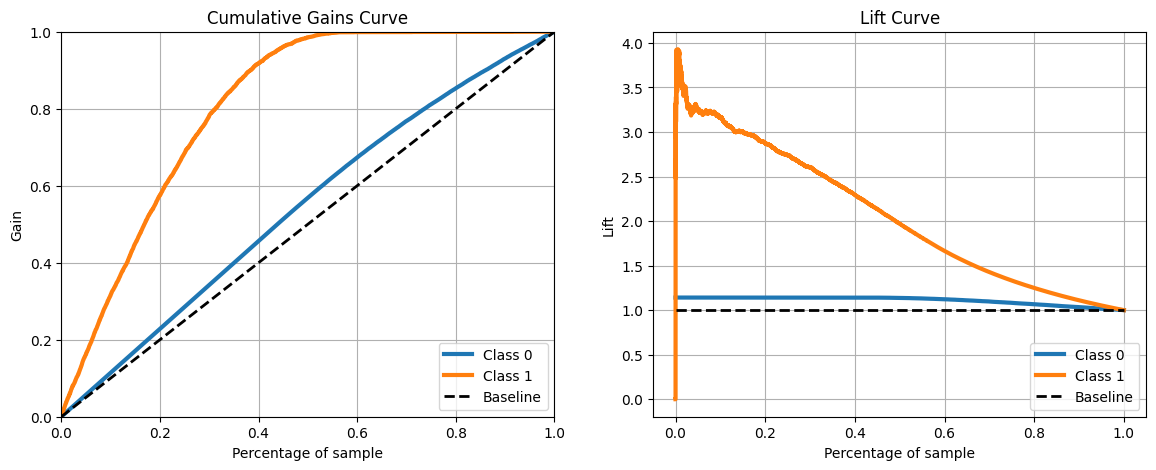

In [93]:
train=pd.concat ([x_train, y_train], axis=1) 

validation=pd.concat ([x_val, y_val], axis=1) 

full = pd.merge(train, validation,how='outer')
full_x=full[cols_selected]
full_y=full['response']


# model definition
lgbm_final = lightgbm.LGBMClassifier(learning_rate=0.1, max_depth=3,
                               min_data_in_leaf=50, num_leaves=40, n_jobs=-1, random_state=42,verbose=-1) 

# model training
lgbm_final.fit(full_x,full_y)

# model prediction
yhat_lgbm_final=lgbm_final.predict_proba(x_test);


df = x_test.copy()
df['response'] = y_test.copy()

# propensity score
df['score'] = yhat_lgbm_final[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=7622 )
precision_at_50, data = precision_at_k( df, k=19055 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=7622 )
recall_at_50, data = recall_at_k( df, k=19055 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_test,yhat_lgbm_final,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve(y_test, yhat_lgbm_final,ax=ax2);

# 9 Business results

## 9.1 Cost, revenue and profit

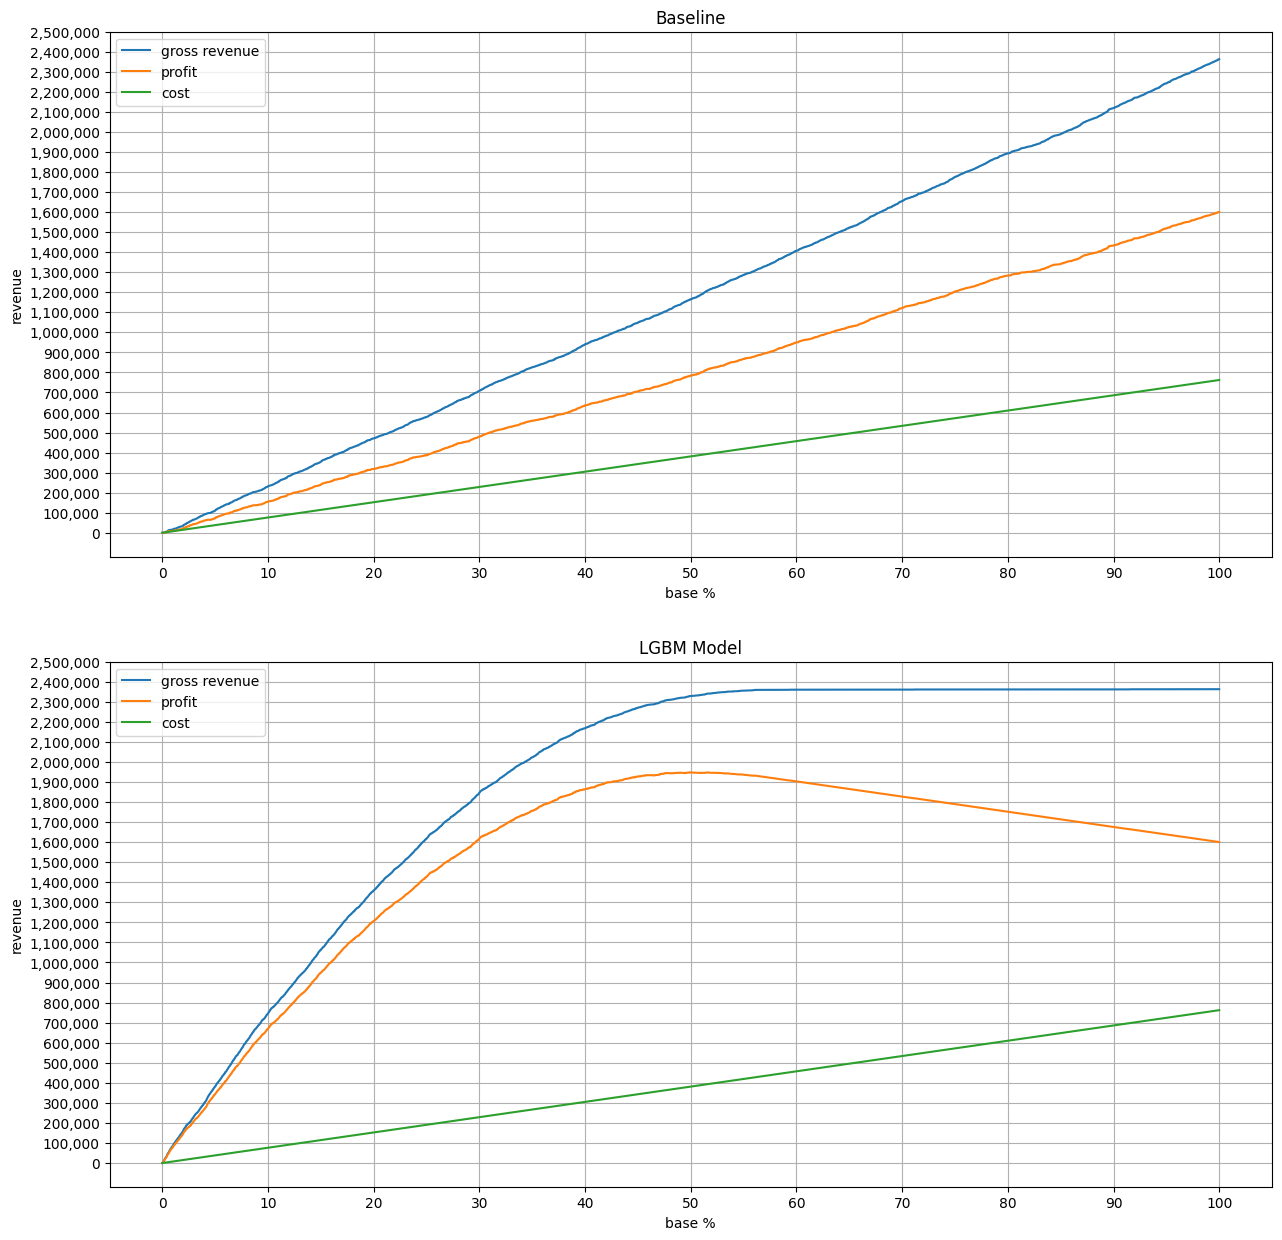

In [105]:
rcParams['figure.figsize'] = 15,15

l1=[0]*33385
l2=[1]* 4726
l=l1+l2
random.shuffle(l)

results = pd.DataFrame()
results['prediction'] = l
results['real'] = y_test.tolist()

# ordering by prediction
results = results.sort_values('prediction', ascending=False)

# Percentage of intereset (Propensity Score)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base (Clients)
results['base'] = range(1, len( results ) + 1)
results['base_cum_perc'] = 100*results['base']/len(results)

results=results.drop(['prediction','real'],axis=1)

cols_new=['n° of interested', '% of interest', 'calls', 'base %']

results.columns=cols_new

# Cost, gross revenue and profit
results['cost'] = 20*results['calls']

results['revenue'] = 500*results['n° of interested'] 

results['profit'] = results['revenue'] - results['cost']

grid=gridspec.GridSpec(2,1)
ax1 = plt.subplot(grid[0,0])

sns.lineplot( x='base %', y='revenue', data=results,ax=ax1,label='gross revenue');
sns.lineplot( x='base %', y='profit', data=results,ax=ax1,label='profit');
sns.lineplot( x='base %', y='cost', data=results,ax=ax1,label='cost');

#=====================================================================

results = pd.DataFrame()
results['prediction'] = yhat_lgbm_final[:,1].tolist()
results['real'] = y_test.tolist()

# ordering by prediction
results = results.sort_values('prediction', ascending=False)

# Percentage of intereset (Propensity Score)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base (Clients)
results['base'] = range(1, len( results ) + 1)
results['base_cum_perc'] = 100*results['base']/len(results)

results=results.drop(['prediction','real'],axis=1)

cols_new=['n° of interested', '% of interest', 'calls', 'base %']

results.columns=cols_new

# Cost, gross revenue and profit
results['cost'] = 20*results['calls']

results['revenue'] = 500*results['n° of interested'] 

results['profit'] = results['revenue'] - results['cost']

ax2 = plt.subplot(grid[1,0])

sns.lineplot( x='base %', y='revenue', data=results,ax=ax2,label='gross revenue');
sns.lineplot( x='base %', y='profit', data=results,ax=ax2,label='profit');
sns.lineplot( x='base %', y='cost', data=results,ax=ax2,label='cost');

yticks=np.arange(0,2500000+1, 100000)
xticks=np.arange(0,100+1, 10)

ax1.set_title('Baseline')
ax1.set_yticks(ticks=yticks);
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_xticks(ticks=xticks);
ax1.grid()

ax2.set_title('LGBM Model')
ax2.set_yticks(ticks=yticks);
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_xticks(ticks=xticks);
ax2.grid() 

## 9.2 Business questions

### 1 - What percentage of customers interested in purchasing auto insurance will the sales team reach by making 10,000 calls?

In [154]:
interest=results.loc[results['calls'] == 10000, '% of interest'].iloc[0]
base=results.loc[results['calls'] == 10000, 'base %'].iloc[0]

print(f'{interest:,.2f}% of interested clients after 10000 calls ({base:,.2f} % of the base)')

70.95% of interested clients after 10000 calls (26.24 % of the base)


### 2 - If the sales team's capacity increases to 20,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to reach?

In [155]:
interest=results.loc[results['calls'] == 20000, '% of interest'].iloc[0]
base=results.loc[results['calls'] == 20000, 'base %'].iloc[0]

print(f'{interest:,.2f}% of interested clients after 20000 calls ({base:,.2f} % of the base)')

99.28% of interested clients after 20000 calls (52.48 % of the base)


### 3 - How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

In [162]:
calls=results.loc[results['n° of interested'] == 3781,'calls'].iloc[0]
base=results.loc[results['n° of interested'] == 3781,'base %'].iloc[0]

print(f'{calls:,.0f} calls to reach 80% of interested customers ({base:,.2f}% of the base)')

11,904 calls to reach 80% of interested customers (31.24% of the base)


# 10 Deploy to production

In [57]:
# save trained model
# pickle.dump(lgbm_final,open('../model/lgbm.pkl','wb')) 

## 10.1 Health Insurance Class

In [9]:
class HealthInsurance:
    
    def __init__(self):        
        self.home_path='/home/soturno/Desktop/pa04/parameters'
        self.annual_premium_scaler =            pickle.load(open(self.home_path + 'annual_premium_scaler.pkl','rb'))
        self.age_scaler =                       pickle.load(open(self.home_path + 'age_scaler.pkl','rb'))
        self.vintage_scaler =                   pickle.load(open(self.home_path + 'vintage_scaler.pkl','rb'))
#         self.target_encode_gender_scaler =      pickle.load(open(self.home_path + ''))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'target_encode_region_code_scaler.pkl','rb')) 
        self.fe_policy_sales_channel_scaler =   pickle.load(open(self.home_path + 'fe_policy_sales_channel_scaler.pkl','rb'))
        
        
    def data_cleaning(df1):        
#         rename columns
        cols_new=['id','gender','age','driving_license','region_code','previously_insured','vehicle_age',
                 'vehicle_damage','annual_premium','policy_sales_channel','vintage']
#         rename
        df1.columns=cols_new
    
        return df1
    
    
    def feature_engineering(self,df2):  
        
#         df2['vehicle_damage']=df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        df2['previously_insured']=df2['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

        df2['driving_license']=df2['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')
#         
        df2['vehicle_age']=df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' 
                                            else 'between_1_2_years' if x == '1-2 Year'
                                            else 'below_1_year')
    
    
    def data_preparation(df5):       
#         annual_premium - standardscaler
        df5['annual_premium']=self.annual_premium_scaler.transform(df5[['annual_premium']].values)
    
#         age - minmaxScaler
        df5['age']=self.age_scaler.transform(df5[['age']].values)
    
#         vintage - minmaxscaler
        df5['vintage']=self.vintage_scaler.transform(df5[['vintage']].values)
        
#         gender 
#         df5['gender']=df5['gender'].map(self.target_encode_gender_scaler)
        df5=pd.get_dummies(df5,prefix='gender',columns=['gender'])

#         region_code - target encoding
        df5['region_code']=df5['region_code'].map(self.target_encode_region_code_scaler)
    
#         vehicle_age - one hot encoding/frequency encoding
        df5=pd.get_dummies(df5,prefix='vehicle_age',columns=['vehicle_age'])
    
#         policy_sales_channel - frequency encoding
        df5['policy_sales_channel']=df5['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)
        
#         previously insured
        df5['previously_insured']=df5['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)
        
#         driving license
        df5['driving_license']=df5['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)
        
#         vehicle damage
        df5['vehicle_damage']=df5['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
    
#         feature selection
        cols_selected=['annual_premium','vintage','age','region_code','vehicle_damage','previously_insured',
                      'policy_sales_channel']
    
        return df5[cols_selected]
    
    
    def get_prediction(self,model,original_data,test_data):   # test_data = produção
#         model prediction
        pred=model.predict_proba(test_data)
    
#         join prediction into original data
        original_data['score']=pred                  # score = prediction
    
        return original_data.to_json(orient='records',date_format='iso')

## 10.2 Api handler

In [10]:
import pickle
import pandas as pd
from flask import Flask,request,Response
from healthinsurance import HealthInsurance


# loading model
path= '' ...health_insurance_cross-sell
model=pickle.load(open(path + '...model_health_insurance.pkl','rb'))


# rabitmq
# redis


# initial API
app=Flask(__name__)   # classe flask instanciada

@app.route('/predict',methods=['POST'])   # api apenas recebe requisições, predict é o endpoint
def health_insurance_predict():
    test_json=request.get_json()
    
    if test_json:  # theres date
        if isinstance(test_json,dict): # unique example         dicionário significa que foi recebido apenas uma linha 
            test_raw=pd.DataFrame(test_json,index=[0])  # ñ necessariamente precisa virar um dataframe (numpy,array etc)
                                                        # index=0 pands precisa da indicação da linha inicial pra criar o df
        else: # multiple example
            test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())  # json significa q foi recebido várias linhas, nome das colunas são as chaves do json
            
#         instantiate health insurance class
        pipeline=HealthInsurance()
    
#         data cleaning
        df1=pipeline.data_cleaning(test_raw)
    
#         feature engineering
        df2=pipeline.feature_engineering(df1)
    
#         data preparation
        df3=pipeline.data_preparation(df2)
    
#         prediction
        df_response=pipeline.get_prediction(model,test_raw,df3)
    
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json')
        
if __name__ == '__main__':
    app.run('0.0.0.0',debug=True)

SyntaxError: invalid syntax (2325977228.py, line 8)

## 10.3 Api tester

In [17]:
import requests
import json

In [18]:
# loading test dataset
# df_test=df_raw.head(100)
# df_test=df_test.drop(['response'],axis=1)

# loading test dataset
test=pd.read_csv('../data/test.csv')
df_test=test.sample(100)
# df_test.to_csv('../data/production_test.csv',index=False)

In [23]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [19]:
# convert dataframe to json
data=json.dumps(df_test.to_dict(orient='records'))

In [20]:
data

'[{"id": 381110, "Gender": "Male", "Age": 25, "Driving_License": 1, "Region_Code": 11.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 35786.0, "Policy_Sales_Channel": 152.0, "Vintage": 53}, {"id": 381111, "Gender": "Male", "Age": 40, "Driving_License": 1, "Region_Code": 28.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 33762.0, "Policy_Sales_Channel": 7.0, "Vintage": 111}, {"id": 381112, "Gender": "Male", "Age": 47, "Driving_License": 1, "Region_Code": 28.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 40050.0, "Policy_Sales_Channel": 124.0, "Vintage": 199}, {"id": 381113, "Gender": "Male", "Age": 24, "Driving_License": 1, "Region_Code": 27.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 37356.0, "Policy_Sales_Channel": 152.0, "Vintage": 187}, {"id": 381114, "Gender": "Male", "Age": 27, "D

In [21]:
# API call
# url='http://0.0.0.0:5000/predict'                            # local test
url='https://car-insurance-interest.onrender.com/predict'      # production test
header={'Content-type':'application/json'}                     
data=data

r=requests.post(url,data=data,headers=header)
print('Status Code {}'.format (r.status_code))

Status Code 200


In [22]:
d1=pd.DataFrame(r.json(),columns=r.json()[0].keys())
d1.sort_values('score',ascending=False).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
93,381203,Male,0.384615,Yes,28.0,No,over_2_years,Yes,1.920061,26.0,130,0.170399
82,381192,Male,0.000000,Yes,28.0,No,between_1_2_years,Yes,0.964584,26.0,235,0.160676
68,381178,Female,0.046154,Yes,24.0,No,below_1_year,Yes,-0.265955,26.0,239,0.159368
50,381160,Female,0.507692,Yes,41.0,No,between_1_2_years,Yes,1.044217,26.0,105,0.143258
89,381199,Male,0.492308,Yes,28.0,No,over_2_years,Yes,0.795640,26.0,268,0.142526
